
Climate data summary:
                      date  temperature    dewpoint  precipitation  \
count                  335   335.000000  335.000000   3.350000e+02   
mean   2024-06-16 00:00:00   289.896089  277.685522   1.339572e-03   
min    2024-01-01 00:00:00   278.171321  259.285433  -1.490116e-08   
25%    2024-03-24 12:00:00   286.318258  272.779643   8.523463e-07   
50%    2024-06-16 00:00:00   290.377789  277.951495   3.013421e-06   
75%    2024-09-07 12:00:00   293.492935  284.455116   8.474154e-04   
max    2024-11-30 00:00:00   299.013709  290.250449   2.856469e-02   
std                    NaN     4.426911    7.886788   3.604590e-03   

           pressure  relative_humidity  
count    335.000000         335.000000  
mean   83958.620907          83.104247  
min    82899.451823          62.959800  
25%    83766.179769          77.947964  
50%    83947.247070          84.118353  
75%    84168.790609          89.396108  
max    84763.848307          97.965356  
std      316.54129

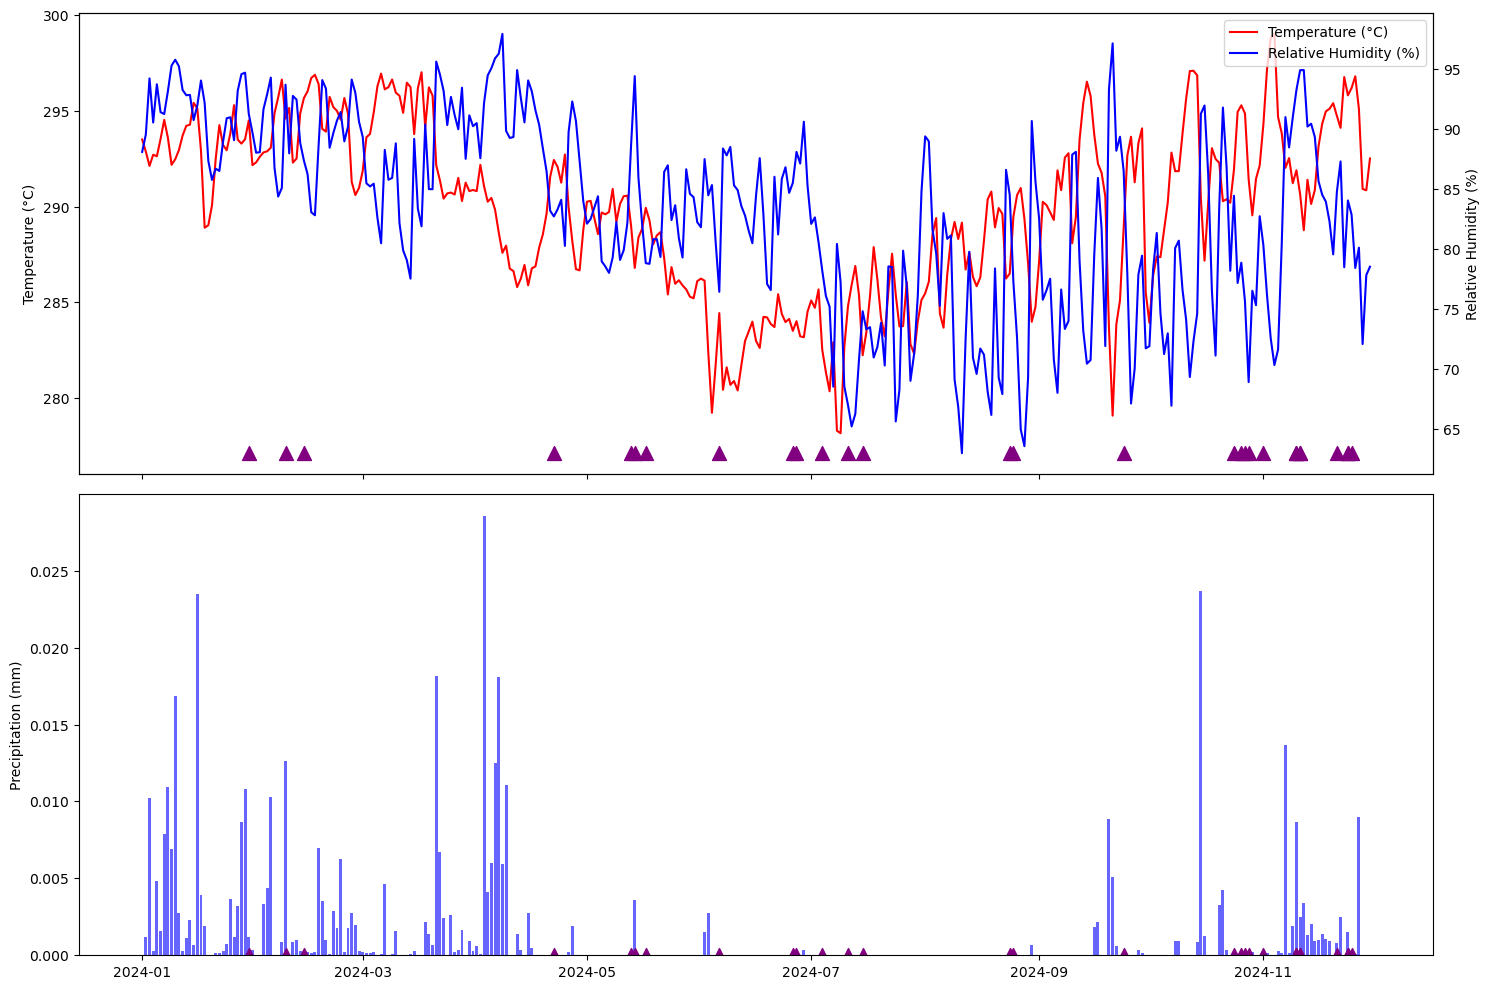

In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize()

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve climate variables from ERA5 with improved error handling
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Create the date range
        date_start = ee.Date(start_date)
        date_end = ee.Date(end_date)
        
        # Get ERA5 dataset
        collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterDate(date_start, date_end) \
            .filterBounds(point) \
            .select([
                'temperature_2m',
                'dewpoint_temperature_2m',
                'total_precipitation_sum',
                'surface_pressure',
            ])
            
        def extract_data(image):
            # Get values for all variables
            values = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=11132  # ERA5-Land resolution
            )
            
            # Create a feature with the values and date
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'temperature': values.get('temperature_2m'),
                'dewpoint': values.get('dewpoint_temperature_2m'),
                'precipitation': values.get('total_precipitation_sum'),
                'pressure': values.get('surface_pressure')
            })
        
        # Map over the collection
        features = collection.map(extract_data)
        
        # Get the data
        data = features.getInfo()
        
        if not data or 'features' not in data:
            print("No data returned from Earth Engine")
            return pd.DataFrame()
            
        # Convert to pandas DataFrame
        rows = []
        for feature in data['features']:
            props = feature['properties']
            if props.get('date'):  # Only add if we have a date
                rows.append({
                    'date': pd.to_datetime(props['date']),
                    'temperature': props.get('temperature'),
                    'dewpoint': props.get('dewpoint'),
                    'precipitation': props.get('precipitation'),
                    'pressure': props.get('pressure')
                })
        
        df = pd.DataFrame(rows)
        
        if df.empty:
            print("No valid data points found")
            return df
            
        # Sort by date
        df = df.sort_values('date')
        
        # Calculate relative humidity
        df['relative_humidity'] = 100 * (np.exp((17.625 * df['dewpoint']) / 
                                               (243.04 + df['dewpoint'])) / 
                                       np.exp((17.625 * df['temperature']) / 
                                             (243.04 + df['temperature'])))
        
        return df
        
    except Exception as e:
        print(f"Error in get_climate_data: {str(e)}")
        return pd.DataFrame()

def plot_climate_health(climate_df, health_df=None):
    if climate_df.empty:
        print("No climate data to plot")
        return None
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Temperature and humidity plot
    ax1.plot(climate_df['date'], climate_df['temperature'], 'r-', 
             label='Temperature (°C)')
    ax1.set_ylabel('Temperature (°C)')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(climate_df['date'], climate_df['relative_humidity'], 
                 'b-', label='Relative Humidity (%)')
    ax1_twin.set_ylabel('Relative Humidity (%)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Precipitation plot
    ax2.bar(climate_df['date'], climate_df['precipitation'], 
            color='blue', alpha=0.6, label='Precipitation (mm)')
    ax2.set_ylabel('Precipitation (mm)')
    
    # Add mental health incidents if available
    if health_df is not None and not health_df.empty:
        for ax in [ax1, ax2]:
            ymin = ax.get_ylim()[0]
            ax.scatter(health_df['date'], [ymin] * len(health_df),
                      marker='^', color='purple', s=100,
                      label='Mental Health Incidents')
            
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

if __name__ == "__main__":
    # Get the climate data
    climate_data = get_climate_data()
    
    if not climate_data.empty:
        print("\nClimate data summary:")
        print(climate_data.describe())
        
        # Load mental health data
        try:
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])
            print("\nMental health data loaded successfully")
        except Exception as e:
            print(f"\nError loading mental health data: {str(e)}")
            health_data = None
        
        # Create and show the plot
        plt = plot_climate_health(climate_data, health_data)
        if plt:
            plt.show()
    else:
        print("Failed to retrieve climate data")

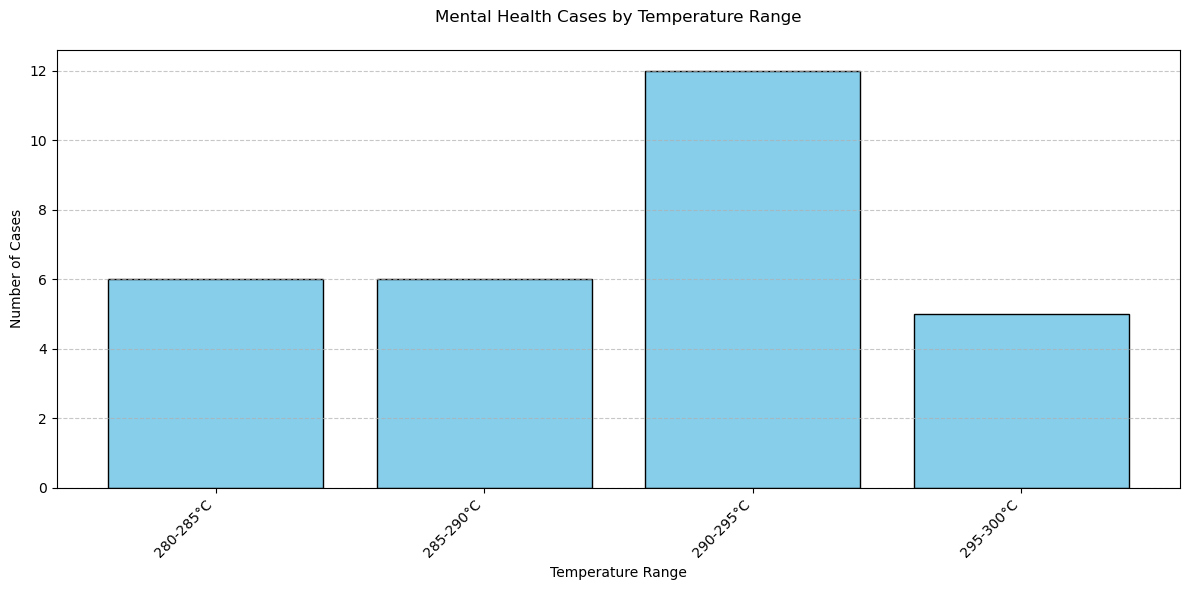


Case counts by temperature bucket:
 temp_bucket  cases temp_range
       280.0      6  280-285°C
       285.0      6  285-290°C
       290.0     12  290-295°C
       295.0      5  295-300°C

Correlation between temperature and daily case count: nan


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def analyze_temp_cases(climate_df, health_df, bucket_size=5, lag_days=0):
    """
    Analyze relationship between temperature and mental health cases.
    
    Parameters:
    climate_df: DataFrame with columns 'date' and 'temperature'
    health_df: DataFrame with column 'date' for incident dates
    bucket_size: Size of temperature buckets in degrees Celsius
    lag_days: Number of days to look back for temperature exposure (0 for same day)
    
    Returns:
    DataFrame with temperature buckets and case counts
    """
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create a mapping of dates to temperatures
    temp_dict = dict(zip(climate_df['date'], climate_df['temperature']))
    
    # Function to get temperature for a case date
    def get_temp(case_date):
        lookup_date = case_date - timedelta(days=lag_days)
        return temp_dict.get(lookup_date)
    
    # Add temperature to each case
    health_df['temperature'] = health_df['date'].apply(get_temp)
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['temperature'] // bucket_size * bucket_size).astype(float)
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')
    
    # Create bucket labels
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    return bucket_counts

def plot_temp_cases(bucket_counts):
    """
    Create a bar plot of cases by temperature bucket.
    
    Parameters:
    bucket_counts: DataFrame with columns 'temp_range' and 'cases'
    """
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    plt.bar(bucket_counts['temp_range'], bucket_counts['cases'], 
            color='skyblue', edgecolor='black')
    
    # Customize plot
    plt.title('Mental Health Cases by Temperature Range', pad=20)
    plt.xlabel('Temperature Range')
    plt.ylabel('Number of Cases')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add grid for easier reading
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage:
if __name__ == "__main__":
    # Using the climate data from your original code
    climate_data = get_climate_data()
    
    # Load mental health data
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze with same-day temperature
        bucket_counts = analyze_temp_cases(climate_data, health_data, 
                                         bucket_size=5, lag_days=0)
        
        # Create and show plot
        plt = plot_temp_cases(bucket_counts)
        plt.show()
        
        # Print summary statistics
        print("\nCase counts by temperature bucket:")
        print(bucket_counts.to_string(index=False))
        
        # Basic correlation analysis
        correlation = health_data['temperature'].corr(
            health_data.groupby('date').size().reindex(health_data['date'])
        )
        print(f"\nCorrelation between temperature and daily case count: {correlation:.3f}")
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

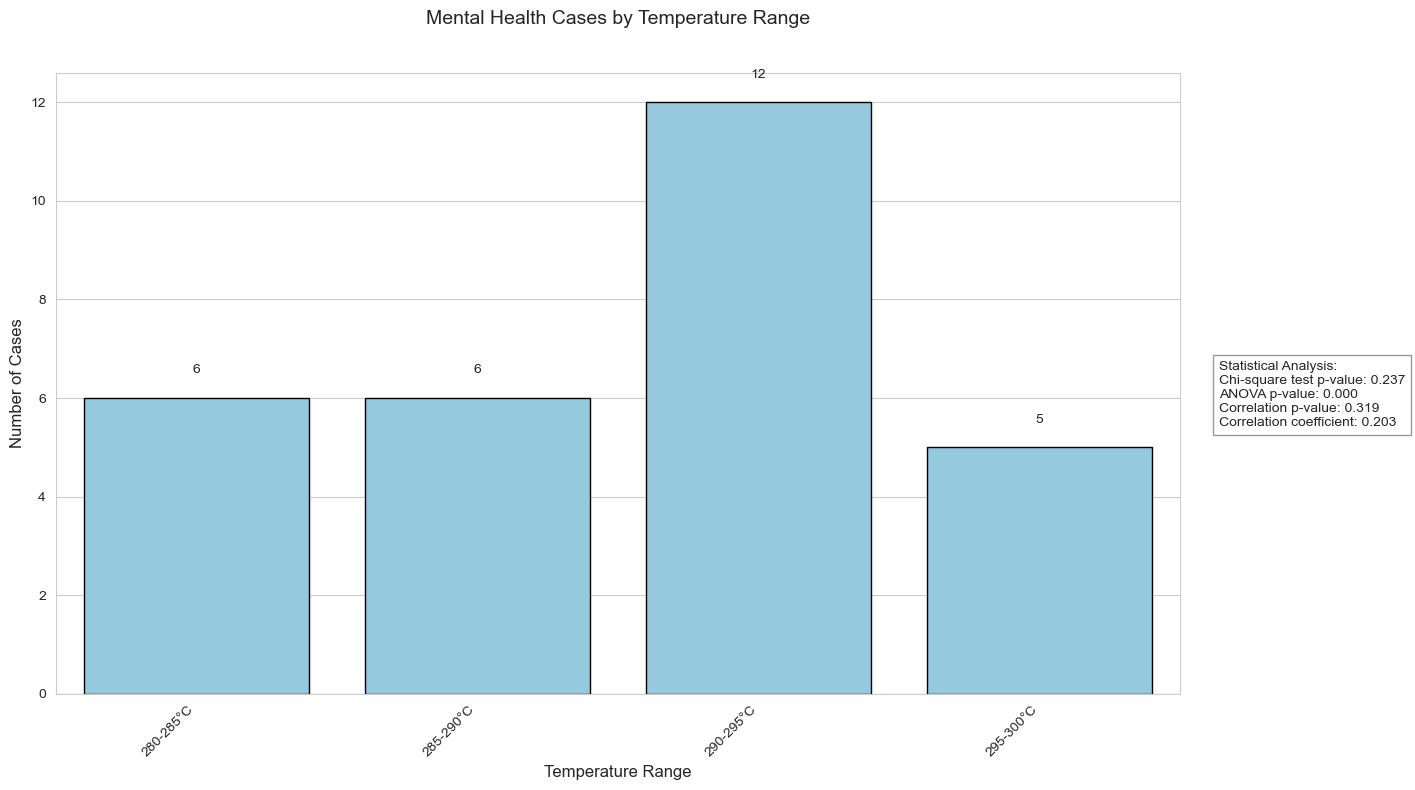


Detailed Statistical Analysis:
chi2_stat: 4.241
chi2_p: 0.237
f_stat: 93.366
anova_p: 0.000
correlation: 0.203
corr_p: 0.319


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def analyze_temp_cases(climate_df, health_df, bucket_size=5, lag_days=0):
    """
    Analyze relationship between temperature and mental health cases with statistical testing.
    """
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create a mapping of dates to temperatures
    temp_dict = dict(zip(climate_df['date'], climate_df['temperature']))
    
    # Function to get temperature for a case date
    def get_temp(case_date):
        lookup_date = case_date - timedelta(days=lag_days)
        return temp_dict.get(lookup_date)
    
    # Add temperature to each case
    health_df['temperature'] = health_df['date'].apply(get_temp)
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['temperature'] // bucket_size * bucket_size).astype(float)
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')
    
    # Create bucket labels
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Perform statistical tests
    # 1. Chi-square test for uniform distribution
    chi2_stat, chi2_p = stats.chisquare(bucket_counts['cases'])
    
    # 2. One-way ANOVA
    temperature_groups = [group['temperature'].dropna() for name, group in 
                        health_df.groupby('temp_bucket')]
    f_stat, anova_p = stats.f_oneway(*temperature_groups)
    
    # 3. Correlation test
    daily_cases = health_df.groupby('date').size()
    daily_temp = health_df.groupby('date')['temperature'].mean()
    corr, corr_p = stats.pearsonr(daily_temp, daily_cases)
    
    stats_results = {
        'chi2_stat': chi2_stat,
        'chi2_p': chi2_p,
        'f_stat': f_stat,
        'anova_p': anova_p,
        'correlation': corr,
        'corr_p': corr_p
    }
    
    return bucket_counts, stats_results

def plot_temp_cases(bucket_counts, stats_results):
    """
    Create an enhanced bar plot of cases by temperature bucket with statistical annotations.
    """
    # Set the style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    ax = sns.barplot(data=bucket_counts, 
                    x='temp_range', 
                    y='cases',
                    color='skyblue',
                    edgecolor='black')
    
    # Customize plot
    plt.title('Mental Health Cases by Temperature Range\n', 
             fontsize=14, pad=20)
    plt.xlabel('Temperature Range', fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add case counts on top of bars
    for i, v in enumerate(bucket_counts['cases']):
        ax.text(i, v + 0.5, str(v), ha='center', fontsize=10)
    
    # Add statistical annotations
    stats_text = f'Statistical Analysis:\n'
    stats_text += f'Chi-square test p-value: {stats_results["chi2_p"]:.3f}\n'
    stats_text += f'ANOVA p-value: {stats_results["anova_p"]:.3f}\n'
    stats_text += f'Correlation p-value: {stats_results["corr_p"]:.3f}\n'
    stats_text += f'Correlation coefficient: {stats_results["correlation"]:.3f}'
    
    # Add text box with statistical results
    plt.figtext(1.02, 0.5, stats_text, 
               bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
               ha='left', va='center')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage:
if __name__ == "__main__":
    # Using the climate data from your original code
    climate_data = get_climate_data()
    
    try:
        # Load mental health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze with same-day temperature
        bucket_counts, stats_results = analyze_temp_cases(climate_data, health_data, 
                                                        bucket_size=5, lag_days=0)
        
        # Create and show enhanced plot
        plt = plot_temp_cases(bucket_counts, stats_results)
        plt.show()
        
        # Print detailed statistics
        print("\nDetailed Statistical Analysis:")
        for key, value in stats_results.items():
            print(f"{key}: {value:.3f}")
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

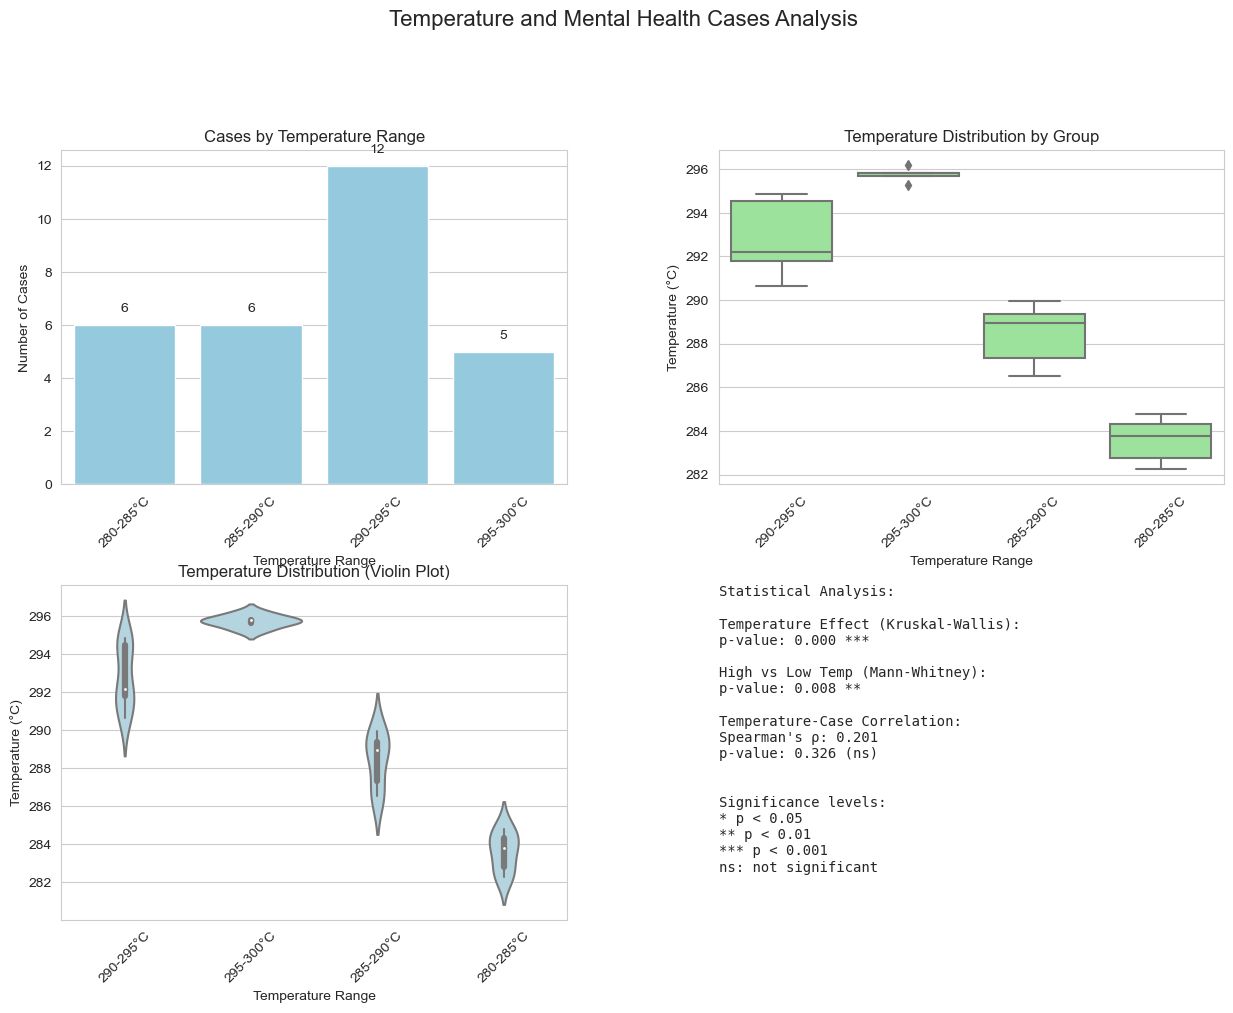

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def analyze_temp_cases(climate_df, health_df, bucket_size=5, lag_days=0):
    """
    Analyze relationship between temperature and mental health cases with statistical testing.
    """
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create a mapping of dates to temperatures
    temp_dict = dict(zip(climate_df['date'], climate_df['temperature']))
    
    # Function to get temperature for a case date
    def get_temp(case_date):
        lookup_date = case_date - timedelta(days=lag_days)
        return temp_dict.get(lookup_date)
    
    # Add temperature to each case
    health_df['temperature'] = health_df['date'].apply(get_temp)
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['temperature'] // bucket_size * bucket_size).astype(float)
    health_df['temp_range'] = health_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Perform statistical tests
    # Kruskal-Wallis H-test (non-parametric alternative to one-way ANOVA)
    temperature_groups = [group['temperature'].dropna() for name, group in 
                        health_df.groupby('temp_bucket')]
    h_stat, kw_p = stats.kruskal(*temperature_groups)
    
    # Mann-Whitney U test between highest and lowest temperature groups
    high_temp_group = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].max()]['temperature']
    low_temp_group = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].min()]['temperature']
    u_stat, mw_p = stats.mannwhitneyu(high_temp_group, low_temp_group, alternative='two-sided')
    
    # Daily correlation
    daily_cases = health_df.groupby('date').size()
    daily_temp = health_df.groupby('date')['temperature'].mean()
    corr, corr_p = stats.spearmanr(daily_temp, daily_cases)
    
    stats_results = {
        'kw_stat': h_stat,
        'kw_p': kw_p,
        'mw_p': mw_p,
        'correlation': corr,
        'corr_p': corr_p
    }
    
    return health_df, bucket_counts, stats_results

def plot_temp_analysis(health_df, bucket_counts, stats_results):
    """
    Create multiple plots for comprehensive temperature analysis.
    """
    # Set the style
    sns.set_style("whitegrid")
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Bar plot with case counts
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(data=bucket_counts, x='temp_range', y='cases', 
                color='skyblue', ax=ax1)
    ax1.set_title('Cases by Temperature Range')
    ax1.set_xlabel('Temperature Range')
    ax1.set_ylabel('Number of Cases')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add case counts on top of bars
    for i, v in enumerate(bucket_counts['cases']):
        ax1.text(i, v + 0.5, str(v), ha='center')
    
    # 2. Box plot of temperature distribution
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(data=health_df, x='temp_range', y='temperature', 
                color='lightgreen', ax=ax2)
    ax2.set_title('Temperature Distribution by Group')
    ax2.set_xlabel('Temperature Range')
    ax2.set_ylabel('Temperature (°C)')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Violin plot
    ax3 = fig.add_subplot(gs[1, 0])
    sns.violinplot(data=health_df, x='temp_range', y='temperature',
                  color='lightblue', ax=ax3)
    ax3.set_title('Temperature Distribution (Violin Plot)')
    ax3.set_xlabel('Temperature Range')
    ax3.set_ylabel('Temperature (°C)')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Statistical results text box
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    # Format p-values with asterisks for significance levels
    def format_pvalue(p):
        if p < 0.001:
            return f"{p:.3f} ***"
        elif p < 0.01:
            return f"{p:.3f} **"
        elif p < 0.05:
            return f"{p:.3f} *"
        else:
            return f"{p:.3f} (ns)"
    
    stats_text = "Statistical Analysis:\n\n"
    stats_text += f"Temperature Effect (Kruskal-Wallis):\n"
    stats_text += f"p-value: {format_pvalue(stats_results['kw_p'])}\n\n"
    stats_text += f"High vs Low Temp (Mann-Whitney):\n"
    stats_text += f"p-value: {format_pvalue(stats_results['mw_p'])}\n\n"
    stats_text += f"Temperature-Case Correlation:\n"
    stats_text += f"Spearman's ρ: {stats_results['correlation']:.3f}\n"
    stats_text += f"p-value: {format_pvalue(stats_results['corr_p'])}\n\n"
    stats_text += "\nSignificance levels:\n"
    stats_text += "* p < 0.05\n** p < 0.01\n*** p < 0.001\nns: not significant"
    
    ax4.text(0, 1, stats_text, va='top', fontfamily='monospace')
    
    plt.suptitle('Temperature and Mental Health Cases Analysis', 
                 fontsize=16, y=1.02)
    
    return plt

# Example usage:
if __name__ == "__main__":
    # Using the climate data from your original code
    climate_data = get_climate_data()
    
    try:
        # Load mental health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze with same-day temperature
        health_df, bucket_counts, stats_results = analyze_temp_cases(
            climate_data, health_data, bucket_size=5, lag_days=0
        )
        
        # Create and show enhanced plots
        plt = plot_temp_analysis(health_df, bucket_counts, stats_results)
        plt.show()
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

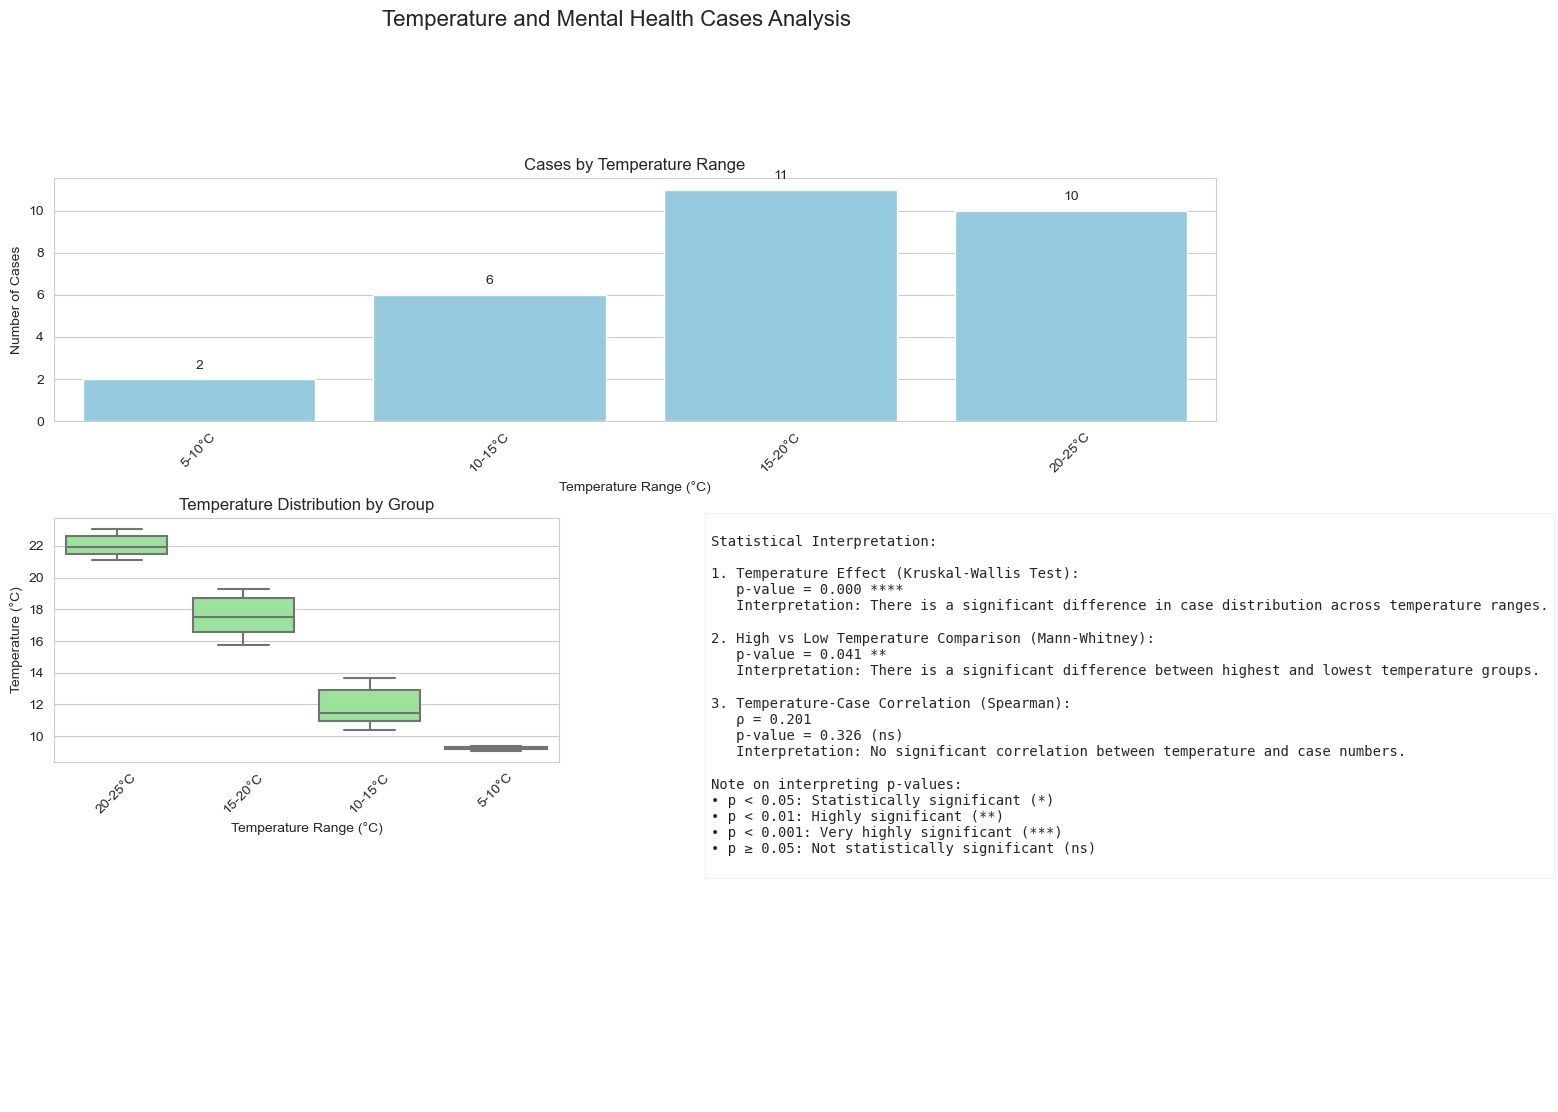

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def kelvin_to_celsius(temp_k):
    """Convert Kelvin to Celsius"""
    return temp_k - 273.15

def analyze_temp_cases(climate_df, health_df, bucket_size=5, lag_days=0):
    """
    Analyze relationship between temperature and mental health cases with statistical testing.
    """
    # Ensure dates are datetime and convert temperature to Celsius
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    climate_df['temperature'] = climate_df['temperature'].apply(kelvin_to_celsius)
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create a mapping of dates to temperatures
    temp_dict = dict(zip(climate_df['date'], climate_df['temperature']))
    
    # Function to get temperature for a case date
    def get_temp(case_date):
        lookup_date = case_date - timedelta(days=lag_days)
        return temp_dict.get(lookup_date)
    
    # Add temperature to each case
    health_df['temperature'] = health_df['date'].apply(get_temp)
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['temperature'] // bucket_size * bucket_size).astype(float)
    health_df['temp_range'] = health_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')  # Ensure proper ordering
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Statistical tests
    # 1. Kruskal-Wallis test for overall temperature effect
    temperature_groups = [group['temperature'].dropna() for name, group in 
                        health_df.groupby('temp_bucket')]
    h_stat, kw_p = stats.kruskal(*temperature_groups)
    
    # 2. Mann-Whitney U test between highest and lowest temperature groups
    high_temp_group = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].max()]['temperature']
    low_temp_group = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].min()]['temperature']
    u_stat, mw_p = stats.mannwhitneyu(high_temp_group, low_temp_group, alternative='two-sided')
    
    # 3. Trend analysis using Spearman correlation
    daily_cases = health_df.groupby('date').size()
    daily_temp = health_df.groupby('date')['temperature'].mean()
    corr, corr_p = stats.spearmanr(daily_temp, daily_cases)
    
    stats_results = {
        'kw_stat': h_stat,
        'kw_p': kw_p,
        'mw_p': mw_p,
        'correlation': corr,
        'corr_p': corr_p
    }
    
    return health_df, bucket_counts, stats_results

def plot_temp_analysis(health_df, bucket_counts, stats_results):
    """
    Create multiple plots with statistical interpretation.
    """
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)
    
    # 1. Bar plot
    ax1 = fig.add_subplot(gs[0, :])
    sns.barplot(data=bucket_counts, x='temp_range', y='cases', 
                color='skyblue', ax=ax1)
    ax1.set_title('Cases by Temperature Range')
    ax1.set_xlabel('Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add case counts on bars
    for i, v in enumerate(bucket_counts['cases']):
        ax1.text(i, v + 0.5, str(v), ha='center')
    
    # 2. Box plot
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=health_df, x='temp_range', y='temperature', 
                color='lightgreen', ax=ax2)
    ax2.set_title('Temperature Distribution by Group')
    ax2.set_xlabel('Temperature Range (°C)')
    ax2.set_ylabel('Temperature (°C)')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Statistical interpretation
    ax3 = fig.add_subplot(gs[1:, 1])
    ax3.axis('off')
    
    interpretation_text = """
Statistical Interpretation:

1. Temperature Effect (Kruskal-Wallis Test):
   p-value = {:.3f} {}
   Interpretation: {}

2. High vs Low Temperature Comparison (Mann-Whitney):
   p-value = {:.3f} {}
   Interpretation: {}

3. Temperature-Case Correlation (Spearman):
   ρ = {:.3f}
   p-value = {:.3f} {}
   Interpretation: {}

Note on interpreting p-values:
• p < 0.05: Statistically significant (*)
• p < 0.01: Highly significant (**)
• p < 0.001: Very highly significant (***)
• p ≥ 0.05: Not statistically significant (ns)
""".format(
        stats_results['kw_p'],
        '*' * (sum([stats_results['kw_p'] < p for p in [0.05, 0.01, 0.001]]) + 1) if stats_results['kw_p'] < 0.05 else '(ns)',
        "There is a significant difference in case distribution across temperature ranges." if stats_results['kw_p'] < 0.05 else "No significant difference in case distribution across temperature ranges.",
        
        stats_results['mw_p'],
        '*' * (sum([stats_results['mw_p'] < p for p in [0.05, 0.01, 0.001]]) + 1) if stats_results['mw_p'] < 0.05 else '(ns)',
        "There is a significant difference between highest and lowest temperature groups." if stats_results['mw_p'] < 0.05 else "No significant difference between temperature extremes.",
        
        stats_results['correlation'],
        stats_results['corr_p'],
        '*' * (sum([stats_results['corr_p'] < p for p in [0.05, 0.01, 0.001]]) + 1) if stats_results['corr_p'] < 0.05 else '(ns)',
        "There is a significant correlation between temperature and case numbers." if stats_results['corr_p'] < 0.05 else "No significant correlation between temperature and case numbers."
    )
    
    ax3.text(0, 1, interpretation_text, va='top', fontfamily='monospace', 
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.1))
    
    plt.suptitle('Temperature and Mental Health Cases Analysis', 
                 fontsize=16, y=1.02)
    
    return plt

# Example usage (as before)
if __name__ == "__main__":
    climate_data = get_climate_data()
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        health_df, bucket_counts, stats_results = analyze_temp_cases(
            climate_data, health_data, bucket_size=5, lag_days=0
        )
        plt = plot_temp_analysis(health_df, bucket_counts, stats_results)
        plt.show()
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_31456\1334204920.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_per_bucket = climate_df.groupby(


Error in analysis: 'intercept'


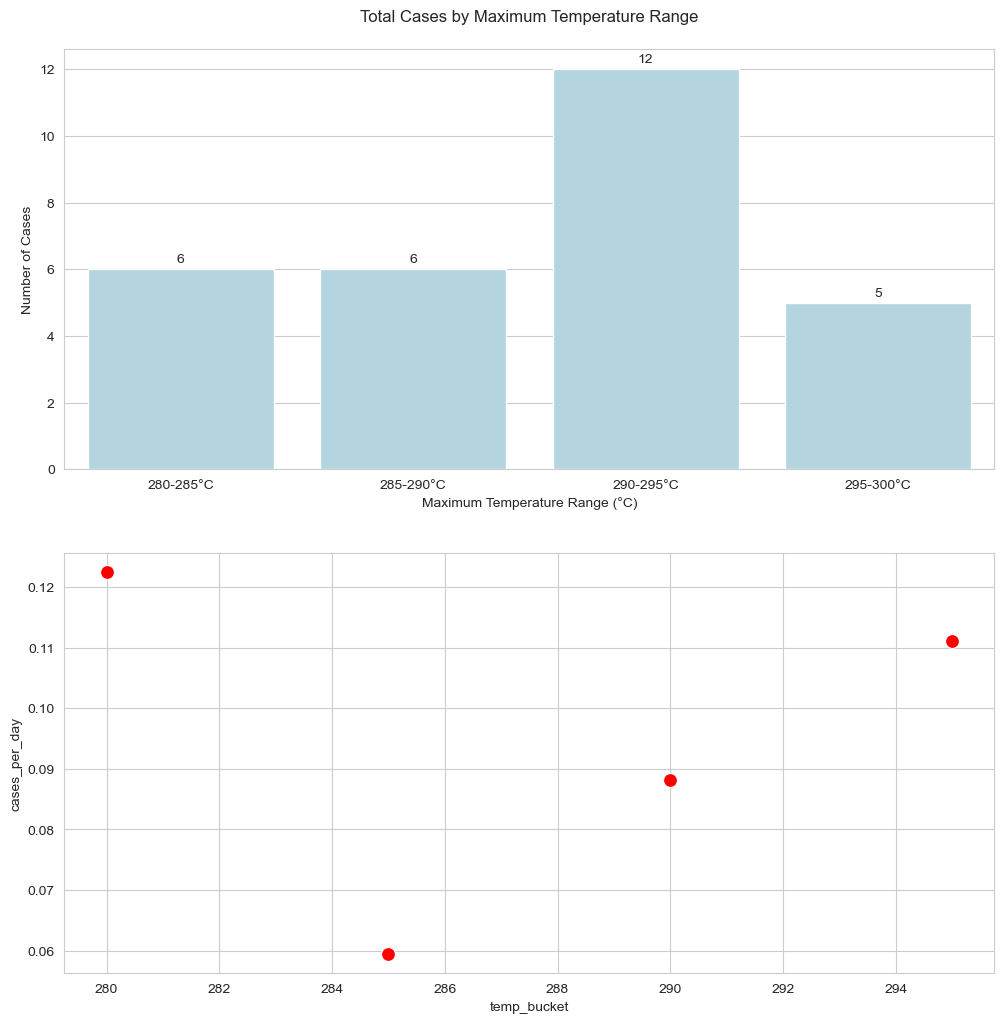

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def analyze_temp_cases(climate_df, health_df, bucket_size=5, lag_days=0):
    """
    Analyze relationship between maximum temperature and mental health cases.
    
    Parameters:
    climate_df: DataFrame with temperature data
    health_df: DataFrame with mental health cases
    bucket_size: Size of temperature buckets in degrees Celsius
    lag_days: Number of days to look back for temperature exposure
    """
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Get daily maximum temperature
    daily_tmax = climate_df.groupby('date')['temperature'].max()
    
    # Create a mapping of dates to max temperatures
    temp_dict = daily_tmax.to_dict()
    
    # Function to get temperature for a case date
    def get_temp(case_date):
        lookup_date = case_date - timedelta(days=lag_days)
        return temp_dict.get(lookup_date)
    
    # Add temperature to each case
    health_df['tmax'] = health_df['date'].apply(get_temp)
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['tmax'] // bucket_size * bucket_size).astype(float)
    health_df['temp_range'] = health_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Calculate cases per day in each temperature range
    days_per_bucket = climate_df.groupby(
        pd.cut(climate_df['temperature'], 
               bins=np.arange(bucket_counts['temp_bucket'].min(),
                             bucket_counts['temp_bucket'].max() + bucket_size + 1,
                             bucket_size))
    ).date.nunique()
    
    bucket_counts['days_in_range'] = days_per_bucket.values
    bucket_counts['cases_per_day'] = bucket_counts['cases'] / bucket_counts['days_in_range']
    
    # Statistical tests
    # Trend analysis using Spearman correlation
    corr, corr_p = stats.spearmanr(bucket_counts['temp_bucket'], 
                                  bucket_counts['cases_per_day'])
    
    # Linear regression for trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        bucket_counts['temp_bucket'], bucket_counts['cases_per_day']
    )
    
    stats_results = {
        'correlation': corr,
        'corr_p': corr_p,
        'slope': slope,
        'p_value': p_value,
        'r_squared': r_value**2
    }
    
    return health_df, bucket_counts, stats_results

def plot_temp_analysis(health_df, bucket_counts, stats_results):
    """
    Create visualization focusing on heat-mental health relationship
    """
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[1, 1])
    
    # 1. Total cases by temperature range
    sns.barplot(data=bucket_counts, x='temp_range', y='cases', 
                color='lightblue', ax=ax1)
    ax1.set_title('Total Cases by Maximum Temperature Range', pad=20)
    ax1.set_xlabel('Maximum Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    
    # Add case counts on bars
    for i, v in enumerate(bucket_counts['cases']):
        ax1.text(i, v + 0.2, str(v), ha='center')
    
    # 2. Cases per day by temperature range (showing heat effect)
    sns.scatterplot(data=bucket_counts, x='temp_bucket', y='cases_per_day',
                   s=100, color='red', ax=ax2)
    
    # Add trend line
    x = bucket_counts['temp_bucket']
    y = bucket_counts['cases_per_day']
    x_line = np.array([x.min(), x.max()])
    y_line = stats_results['slope'] * x_line + stats_results['intercept']
    ax2.plot(x_line, y_line, color='blue', linestyle='--', 
             label=f'Trend line (R² = {stats_results["r_squared"]:.3f})')
    
    ax2.set_title('Cases per Day vs Maximum Temperature\n'
                  f'(Correlation: {stats_results["correlation"]:.2f}, '
                  f'p-value: {stats_results["p_value"]:.3f})')
    ax2.set_xlabel('Maximum Temperature (°C)')
    ax2.set_ylabel('Average Cases per Day')
    ax2.legend()
    
    # Add interpretation text
    interpretation = (
        f"Heat-Mental Health Relationship Analysis:\n\n"
        f"1. Trend Analysis:\n"
        f"   - Direction: {'Positive' if stats_results['slope'] > 0 else 'Negative'} relationship\n"
        f"   - Strength: R² = {stats_results['r_squared']:.3f}\n"
        f"   - Statistical significance: p = {stats_results['p_value']:.3f}\n\n"
        f"2. Interpretation:\n"
        f"   {'There is a significant relationship between temperature and cases' if stats_results['p_value'] < 0.05 else 'No significant relationship detected'}\n"
        f"   Average increase of {stats_results['slope']:.3f} cases per degree Celsius"
    )
    
    plt.figtext(1.02, 0.5, interpretation, 
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
                fontsize=10, ha='left', va='center')
    
    plt.tight_layout()
    return plt

# Example usage:
if __name__ == "__main__":
    climate_data = get_climate_data()
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze using maximum temperature
        health_df, bucket_counts, stats_results = analyze_temp_cases(
            climate_data, health_data, bucket_size=5, lag_days=0
        )
        
        plt = plot_temp_analysis(health_df, bucket_counts, stats_results)
        plt.show()
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def kelvin_to_celsius(temp_k):
    """Convert Kelvin to Celsius"""
    return temp_k - 273.15

def analyze_temp_cases(climate_df, health_df, bucket_size=3, lag_days=0):
    """
    Analyze relationship between maximum temperature and mental health cases.
    """
    # Convert temperature to Celsius
    climate_df = climate_df.copy()
    climate_df['temperature'] = climate_df['temperature'].apply(kelvin_to_celsius)
    
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Get daily maximum temperature
    daily_tmax = climate_df.groupby('date')['temperature'].max()
    
    # Create a mapping of dates to max temperatures
    temp_dict = daily_tmax.to_dict()
    
    # Add temperature to each case
    health_df['tmax'] = health_df['date'].apply(lambda x: temp_dict.get(x - timedelta(days=lag_days)))
    
    # Create temperature buckets
    health_df['temp_bucket'] = (health_df['tmax'] // bucket_size * bucket_size).astype(float)
    health_df['temp_range'] = health_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Count cases in each bucket
    bucket_counts = health_df['temp_bucket'].value_counts().reset_index()
    bucket_counts.columns = ['temp_bucket', 'cases']
    bucket_counts = bucket_counts.sort_values('temp_bucket')
    bucket_counts['temp_range'] = bucket_counts['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Calculate cases per day in each temperature range
    temp_bins = pd.cut(climate_df['temperature'], 
                      bins=np.arange(bucket_counts['temp_bucket'].min(),
                                   bucket_counts['temp_bucket'].max() + bucket_size + 1,
                                   bucket_size))
    days_per_bucket = climate_df.groupby(temp_bins)['date'].nunique()
    
    bucket_counts['days_in_range'] = days_per_bucket.values
    bucket_counts['cases_per_day'] = bucket_counts['cases'] / bucket_counts['days_in_range']
    
    # Statistical tests
    # 1. Chi-square test for uniform distribution
    chi2_stat, chi2_p = stats.chisquare(bucket_counts['cases'])
    
    # 2. Spearman correlation
    corr, corr_p = stats.spearmanr(bucket_counts['temp_bucket'], bucket_counts['cases'])
    
    # 3. Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        bucket_counts['temp_bucket'], bucket_counts['cases']
    )
    
    # 4. Mann-Whitney U test comparing cases in highest vs lowest temperature buckets
    high_temp = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].max()]['cases']
    low_temp = health_df[health_df['temp_bucket'] == health_df['temp_bucket'].min()]['cases']
    mw_stat, mw_p = stats.mannwhitneyu(high_temp, low_temp, alternative='two-sided')
    
    stats_results = {
        'chi2_stat': chi2_stat,
        'chi2_p': chi2_p,
        'correlation': corr,
        'corr_p': corr_p,
        'regression_slope': slope,
        'regression_p': p_value,
        'r_squared': r_value**2,
        'mw_p': mw_p
    }
    
    return health_df, bucket_counts, stats_results

def plot_temp_analysis(health_df, bucket_counts, stats_results):
    """
    Create visualization with statistical analysis
    """
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Cases by temperature range
    sns.barplot(data=bucket_counts, x='temp_range', y='cases', 
                color='skyblue', ax=ax1)
    ax1.set_title('Cases by Maximum Temperature Range', pad=20)
    ax1.set_xlabel('Maximum Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    
    # Add case counts on bars
    for i, v in enumerate(bucket_counts['cases']):
        ax1.text(i, v + 0.2, str(v), ha='center')
    
    # 2. Statistical summary and interpretation
    ax2.axis('off')
    
    # Format p-values with significance stars
    def format_pvalue(p):
        if p < 0.001:
            return f"{p:.3f} ***"
        elif p < 0.01:
            return f"{p:.3f} **"
        elif p < 0.05:
            return f"{p:.3f} *"
        else:
            return f"{p:.3f} (ns)"
    
    stats_text = """
Statistical Analysis:

1. Distribution Test (Chi-square):
   p-value: {}
   Interpretation: {} distribution of cases across temperature ranges
   
2. Temperature-Case Relationship:
   • Correlation coefficient: {:.3f}
   • Correlation p-value: {}
   • R-squared value: {:.3f}
   Interpretation: {} relationship between temperature and cases
   
3. High vs Low Temperature Comparison:
   • Mann-Whitney U test p-value: {}
   Interpretation: {} difference between highest and lowest temperature groups

4. Trend Analysis:
   • Slope: {:.3f} cases per °C
   Interpretation: {} in cases with increasing temperature

Significance levels:
* p < 0.05   | ** p < 0.01   | *** p < 0.001   | ns: not significant
    """.format(
        format_pvalue(stats_results['chi2_p']),
        'Non-uniform' if stats_results['chi2_p'] < 0.05 else 'Uniform',
        
        stats_results['correlation'],
        format_pvalue(stats_results['corr_p']),
        stats_results['r_squared'],
        'Significant' if stats_results['corr_p'] < 0.05 else 'No significant',
        
        format_pvalue(stats_results['mw_p']),
        'Significant' if stats_results['mw_p'] < 0.05 else 'No significant',
        
        stats_results['regression_slope'],
        'Significant increase' if stats_results['regression_p'] < 0.05 and stats_results['regression_slope'] > 0
        else 'Significant decrease' if stats_results['regression_p'] < 0.05 and stats_results['regression_slope'] < 0
        else 'No significant change'
    )
    
    ax2.text(0, 1, stats_text, va='top', fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.1))
    
    plt.tight_layout()
    return plt

# Example usage:
if __name__ == "__main__":
    climate_data = get_climate_data()
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze using maximum temperature with 3°C buckets
        health_df, bucket_counts, stats_results = analyze_temp_cases(
            climate_data, health_data, bucket_size=3, lag_days=0
        )
        
        plt = plot_temp_analysis(health_df, bucket_counts, stats_results)
        plt.show()
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

Error in analysis: 'cases'


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_31456\2708532731.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_per_bucket = climate_df.groupby(temp_bins)['date'].nunique()


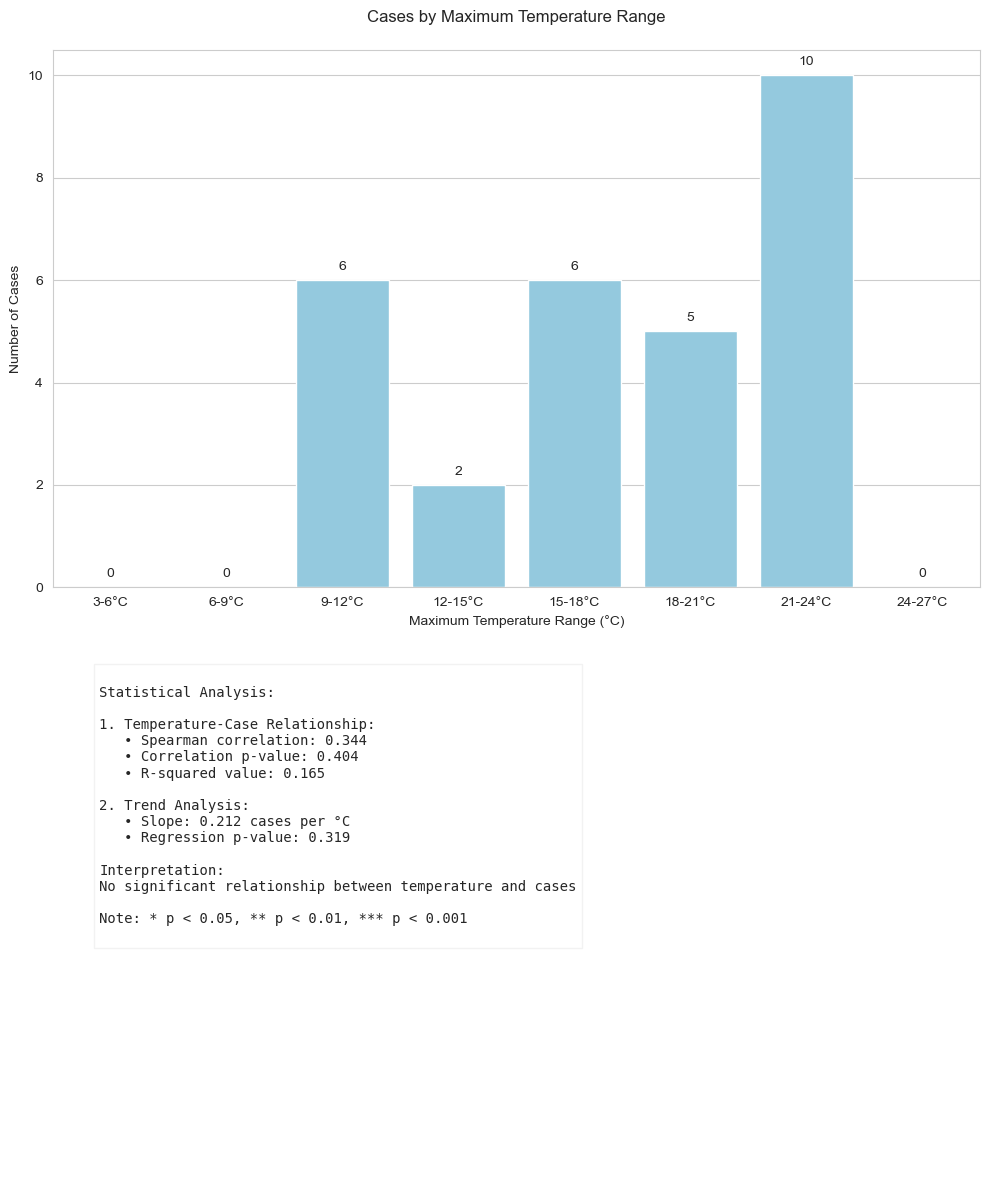

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

def kelvin_to_celsius(temp_k):
    """Convert Kelvin to Celsius"""
    return temp_k - 273.15

def analyze_temp_cases(climate_df, health_df, bucket_size=3, lag_days=0):
    """
    Analyze relationship between maximum temperature and mental health cases.
    """
    # Convert temperature to Celsius
    climate_df = climate_df.copy()
    climate_df['temperature'] = climate_df['temperature'].apply(kelvin_to_celsius)
    
    # Ensure dates are datetime
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Get daily maximum temperature
    daily_tmax = climate_df.groupby('date')['temperature'].max()
    
    # Count daily cases
    daily_cases = health_df['date'].value_counts().reindex(daily_tmax.index).fillna(0)
    
    # Combine temperature and cases
    analysis_df = pd.DataFrame({
        'temperature': daily_tmax,
        'cases': daily_cases
    }).reset_index()
    
    # Create temperature buckets
    analysis_df['temp_bucket'] = (analysis_df['temperature'] // bucket_size * bucket_size).astype(float)
    analysis_df['temp_range'] = analysis_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Aggregate by temperature bucket
    bucket_counts = analysis_df.groupby('temp_range').agg({
        'cases': 'sum',
        'temperature': ['count', 'mean']
    }).reset_index()
    
    bucket_counts.columns = ['temp_range', 'total_cases', 'days_in_range', 'mean_temp']
    bucket_counts['cases_per_day'] = bucket_counts['total_cases'] / bucket_counts['days_in_range']
    
    # Sort by temperature
    bucket_counts = bucket_counts.sort_values('mean_temp')
    
    # Statistical tests
    # 1. Chi-square test
    chi2_stat, chi2_p = stats.chisquare(bucket_counts['total_cases'])
    
    # 2. Spearman correlation
    corr, corr_p = stats.spearmanr(bucket_counts['mean_temp'], bucket_counts['total_cases'])
    
    # 3. Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        bucket_counts['mean_temp'], bucket_counts['total_cases']
    )
    
    stats_results = {
        'chi2_stat': chi2_stat,
        'chi2_p': chi2_p,
        'correlation': corr,
        'corr_p': corr_p,
        'regression_slope': slope,
        'regression_p': p_value,
        'r_squared': r_value**2
    }
    
    return bucket_counts, stats_results

def plot_temp_analysis(bucket_counts, stats_results):
    """
    Create visualization with statistical analysis
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # 1. Bar plot of cases
    sns.barplot(data=bucket_counts, x='temp_range', y='total_cases', 
                color='skyblue', ax=ax1)
    ax1.set_title('Cases by Maximum Temperature Range', pad=20)
    ax1.set_xlabel('Maximum Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    
    # Add case counts on bars
    for i, v in enumerate(bucket_counts['total_cases']):
        ax1.text(i, v + 0.2, str(int(v)), ha='center')
    
    # Add statistical summary
    stats_text = f"""
Statistical Analysis:

1. Temperature-Case Relationship:
   • Spearman correlation: {stats_results['correlation']:.3f}
   • Correlation p-value: {stats_results['corr_p']:.3f}
   • R-squared value: {stats_results['r_squared']:.3f}

2. Trend Analysis:
   • Slope: {stats_results['regression_slope']:.3f} cases per °C
   • Regression p-value: {stats_results['regression_p']:.3f}

Interpretation:
{'Significant positive relationship between temperature and cases' 
 if stats_results['corr_p'] < 0.05 and stats_results['correlation'] > 0
 else 'Significant negative relationship between temperature and cases' 
 if stats_results['corr_p'] < 0.05 and stats_results['correlation'] < 0
 else 'No significant relationship between temperature and cases'}

Note: * p < 0.05, ** p < 0.01, *** p < 0.001
"""
    ax2.text(0.05, 0.95, stats_text, 
             transform=ax2.transAxes,
             verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.1))
    ax2.axis('off')
    
    plt.tight_layout()
    return plt

# Example usage:
if __name__ == "__main__":
    climate_data = get_climate_data()
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Analyze using maximum temperature
        bucket_counts, stats_results = analyze_temp_cases(
            climate_data, health_data, bucket_size=3, lag_days=0
        )
        
        plt = plot_temp_analysis(bucket_counts, stats_results)
        plt.show()
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

In [9]:
import ee
import pandas as pd
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize()

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve maximum daily temperatures from ERA5-Land
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Create the date range
        date_start = ee.Date(start_date)
        date_end = ee.Date(end_date)
        
        # Get ERA5-Land hourly data instead of daily aggregate
        collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
            .filterDate(date_start, date_end) \
            .filterBounds(point) \
            .select(['temperature_2m'])
        
        # Get daily maximum temperature
        def get_daily_max(date):
            start = ee.Date(date)
            end = start.advance(1, 'day')
            daily_images = collection.filterDate(start, end)
            
            max_temp = daily_images.max()
            
            return max_temp.set('date', date)
        
        # Generate daily dates
        days = ee.List.sequence(0, date_end.difference(date_start, 'day'))
        dates = days.map(lambda d: date_start.advance(d, 'day'))
        
        # Map over dates to get daily maximum
        daily_max = ee.ImageCollection.fromImages(
            dates.map(get_daily_max)
        )
            
        def extract_data(image):
            # Get maximum temperature value
            values = image.reduceRegion(
                reducer=ee.Reducer.first(),  # Use first since we've already computed max
                geometry=point,
                scale=1000  # Reduced scale for better urban temperature representation
            )
            
            # Create a feature with the values and date
            return ee.Feature(None, {
                'date': image.get('date'),
                'temperature': values.get('temperature_2m')
            })
        
        # Map over the collection
        features = daily_max.map(extract_data)
        
        # Get the data
        data = features.getInfo()
        
        if not data or 'features' not in data:
            print("No data returned from Earth Engine")
            return pd.DataFrame()
            
        # Convert to pandas DataFrame
        rows = []
        for feature in data['features']:
            props = feature['properties']
            if props.get('date'):  # Only add if we have a date
                rows.append({
                    'date': pd.to_datetime(props['date']),
                    'temperature': props.get('temperature')
                })
        
        df = pd.DataFrame(rows)
        
        if df.empty:
            print("No valid data points found")
            return df
            
        # Sort by date
        df = df.sort_values('date')
        
        return df
        
    except Exception as e:
        print(f"Error in get_climate_data: {str(e)}")
        return pd.DataFrame()

In [13]:
import ee
import pandas as pd
from datetime import datetime, timedelta

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve temperature data from ERA5 monthly aggregates
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Create the date range
        date_start = ee.Date(start_date)
        date_end = ee.Date(end_date)
        
        # Get ERA5 monthly data
        collection = ee.ImageCollection('ECMWF/ERA5/MONTHLY') \
            .filterDate(date_start, date_end) \
            .filterBounds(point) \
            .select('mean_2m_air_temperature')  # Different band name in monthly data
        
        def extract_temp(image):
            # Get temperature value at point
            temp = image.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=point,
                scale=1000
            ).get('mean_2m_air_temperature')
            
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'temperature': temp
            })
        
        features = collection.map(extract_temp)
        data = features.getInfo()
        
        if not data or 'features' not in data:
            print("No data returned from Earth Engine")
            return pd.DataFrame()
        
        # Convert to DataFrame
        rows = []
        for feature in data['features']:
            props = feature['properties']
            if props.get('date') and props.get('temperature') is not None:
                rows.append({
                    'date': pd.to_datetime(props['date']),
                    'temperature': float(props['temperature'])
                })
        
        df = pd.DataFrame(rows)
        
        if df.empty:
            print("No valid data points found")
            return df
        
        # Convert to Celsius and sort
        df['temperature_celsius'] = df['temperature'] - 273.15
        df = df.sort_values('date')
        
        # Print summary statistics
        print("\nTemperature Summary (Celsius):")
        print(f"Min: {df['temperature_celsius'].min():.1f}°C")
        print(f"Max: {df['temperature_celsius'].max():.1f}°C")
        print(f"Mean: {df['temperature_celsius'].mean():.1f}°C")
        
        # Show the first few rows
        print("\nFirst few rows of temperature data:")
        print(df.head().to_string())
        
        return df
        
    except Exception as e:
        print(f"Error in get_climate_data: {str(e)}")
        if isinstance(e, ee.EEException):
            print("Earth Engine specific error:")
            print("1. Check if Earth Engine is initialized")
            print("2. Verify your authentication")
            print("3. Confirm you have access to the ERA5 dataset")
        return pd.DataFrame()

# Test the function
if __name__ == "__main__":
    try:
        # Initialize Earth Engine
        ee.Initialize()
        print("Earth Engine initialized successfully")
        
        df = get_climate_data()
        if not df.empty:
            print("\nSuccessfully retrieved temperature data")
        
    except Exception as e:
        print(f"Failed to initialize Earth Engine: {str(e)}")

Earth Engine initialized successfully
No valid data points found


In [4]:
import ee
import pandas as pd
from datetime import datetime, timedelta

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2023-01-01', end_date='2023-12-31'):  # Using 2023 as safe default
    """
    Retrieve temperature data from ERA5
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Create the date range
        date_start = ee.Date(start_date)
        date_end = ee.Date(end_date)
        
        # Try ERA5 daily aggregates collection
        collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterDate(date_start, date_end) \
            .filterBounds(point)
            
        # Print available bands
        first_image = collection.first()
        print("Available bands:", first_image.bandNames().getInfo())
        
        # Get maximum daily temperature
        collection = collection.select('temperature_2m_max')
        
        def extract_temp(image):
            # Extract temperature value
            temp = image.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=point,
                scale=1000
            ).get('temperature_2m_max')
            
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'temperature': temp
            })
        
        # Map over collection
        features = collection.map(extract_temp)
        print("Processing features...")
        
        data = features.getInfo()
        print(f"Retrieved {len(data.get('features', []))} data points")
        
        if not data or 'features' not in data:
            print("No data returned from Earth Engine")
            return pd.DataFrame()
        
        # Convert to DataFrame
        rows = []
        for feature in data['features']:
            props = feature['properties']
            if props.get('date') and props.get('temperature') is not None:
                rows.append({
                    'date': pd.to_datetime(props['date']),
                    'temperature': float(props['temperature'])
                })
        
        df = pd.DataFrame(rows)
        
        if df.empty:
            print("No valid data points found")
            return df
        
        # Convert to Celsius and sort
        df['temperature_celsius'] = df['temperature'] - 273.15
        df = df.sort_values('date')
        
        # Print summary
        print(f"\nRetrieved {len(df)} days of temperature data")
        print("\nDate range:")
        print(f"Start: {df['date'].min()}")
        print(f"End: {df['date'].max()}")
        
        print("\nTemperature Summary (Celsius):")
        print(f"Min: {df['temperature_celsius'].min():.1f}°C")
        print(f"Max: {df['temperature_celsius'].max():.1f}°C")
        print(f"Mean: {df['temperature_celsius'].mean():.1f}°C")
        
        return df
        
    except Exception as e:
        print(f"Error in get_climate_data: {str(e)}")
        print("\nDebug info:")
        print(f"Requested date range: {start_date} to {end_date}")
        print(f"Location: {latitude}, {longitude}")
        return pd.DataFrame()

# Test the function
if __name__ == "__main__":
    try:
        # Initialize Earth Engine
        ee.Initialize()
        print("Earth Engine initialized successfully")
        
        # Read the health data to get the date range
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        health_data['date'] = pd.to_datetime(health_data['date'])
        
        # Get the date range from health data
        start_date = health_data['date'].min().strftime('%Y-%m-%d')
        end_date = health_data['date'].max().strftime('%Y-%m-%d')
        
        print(f"\nUsing date range from health data: {start_date} to {end_date}")
        
        df = get_climate_data(start_date=start_date, end_date=end_date)
        if not df.empty:
            print("\nSuccessfully retrieved temperature data")
            print("\nFirst few rows:")
            print(df.head().to_string())
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")

Earth Engine initialized successfully

Using date range from health data: 2024-01-30 to 2024-11-25
Available bands: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'surface_thermal_radiat

Loading health data...

Starting analysis...
Data Validation:

Climate Data:
Original rows: 300
Temperature range: 7.1°C to 33.4°C
Date range: 2024-01-30 00:00:00 to 2024-11-24 00:00:00

Health Data:
Original rows: 29
Date range: 2024-01-30 00:00:00 to 2024-11-25 00:00:00

Merged data summary:
Total rows: 300
Total cases: 28


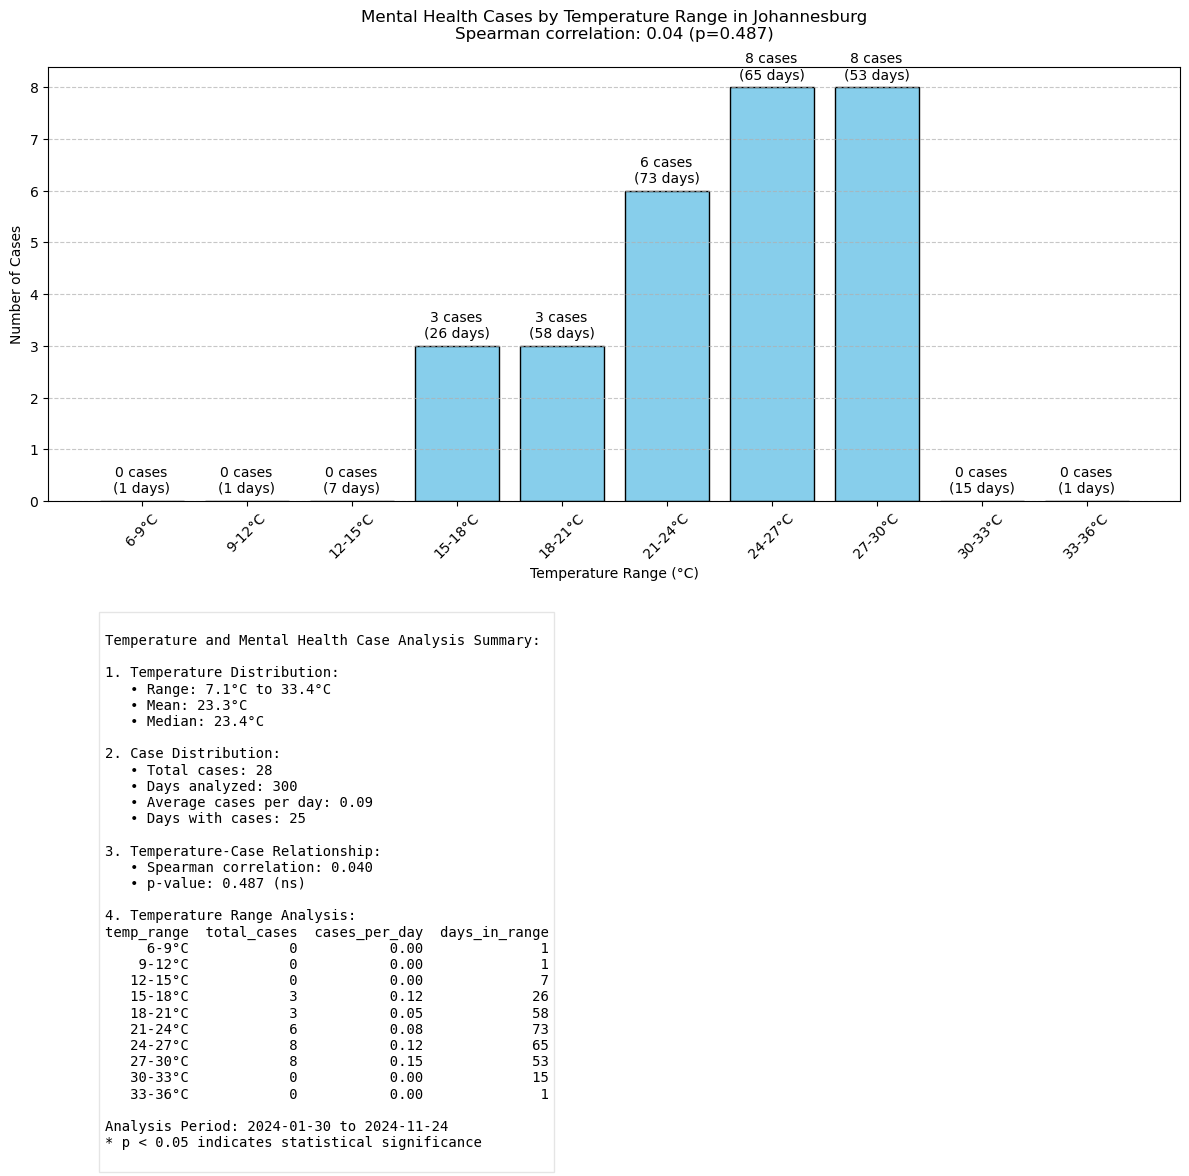

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_temp_health_relationship(climate_df, health_df, temp_bucket_size=3):
    """
    Analyze relationship between temperature and mental health cases
    """
    print("Data Validation:")
    
    # Check and clean climate data
    print("\nClimate Data:")
    print(f"Original rows: {len(climate_df)}")
    climate_df = climate_df.copy()
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    print(f"Temperature range: {climate_df['temperature_celsius'].min():.1f}°C to {climate_df['temperature_celsius'].max():.1f}°C")
    print(f"Date range: {climate_df['date'].min()} to {climate_df['date'].max()}")
    
    # Check and clean health data
    print("\nHealth Data:")
    print(f"Original rows: {len(health_df)}")
    health_df = health_df.copy()
    health_df['date'] = pd.to_datetime(health_df['date'])
    health_df = health_df.dropna(subset=['date'])
    print(f"Date range: {health_df['date'].min()} to {health_df['date'].max()}")
    
    # Create daily case counts
    daily_cases = pd.DataFrame(index=pd.date_range(start=climate_df['date'].min(),
                                                  end=climate_df['date'].max()))
    case_counts = health_df['date'].value_counts()
    daily_cases['cases'] = case_counts.reindex(daily_cases.index).fillna(0)
    
    # Merge temperature and case data
    merged_df = pd.DataFrame({
        'date': climate_df['date'],
        'temperature': climate_df['temperature_celsius'],
        'cases': daily_cases.loc[climate_df['date'], 'cases'].values
    })
    
    print(f"\nMerged data summary:")
    print(f"Total rows: {len(merged_df)}")
    print(f"Total cases: {int(merged_df['cases'].sum())}")
    
    if merged_df.empty:
        raise ValueError("No valid data after merging temperature and case data")
        
    # Create temperature buckets
    merged_df['temp_bucket'] = (merged_df['temperature'] // temp_bucket_size) * temp_bucket_size
    merged_df['temp_range'] = merged_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + temp_bucket_size)}°C"
    )
    
    # Calculate statistics
    temp_analysis = merged_df.groupby('temp_range').agg({
        'cases': ['sum', 'count', 'mean'],
        'temperature': ['mean', 'min', 'max']
    }).round(2)
    
    temp_analysis.columns = ['total_cases', 'days_in_range', 'cases_per_day', 
                           'mean_temp', 'min_temp', 'max_temp']
    temp_analysis = temp_analysis.reset_index()
    
    # Sort by temperature
    temp_analysis['sort_temp'] = temp_analysis['min_temp']
    temp_analysis = temp_analysis.sort_values('sort_temp')
    
    # Safe integer conversion
    temp_analysis['total_cases'] = temp_analysis['total_cases'].fillna(0).astype(int)
    temp_analysis['days_in_range'] = temp_analysis['days_in_range'].fillna(0).astype(int)
    
    # Statistical tests
    corr, p_value = stats.spearmanr(merged_df['temperature'], merged_df['cases'])
    
    # Create visualization
    plt.figure(figsize=(12, 12))
    
    # Create subplot layout
    gs = plt.GridSpec(2, 1, height_ratios=[1, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    # Plot cases by temperature
    bars = ax1.bar(range(len(temp_analysis)), temp_analysis['total_cases'], 
                   color='skyblue', edgecolor='black')
    
    ax1.set_title('Mental Health Cases by Temperature Range in Johannesburg\n' +
                  f'Spearman correlation: {corr:.2f} (p={p_value:.3f})',
                  pad=20)
    ax1.set_xlabel('Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    ax1.set_xticks(range(len(temp_analysis)))
    ax1.set_xticklabels(temp_analysis['temp_range'], rotation=45)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add labels on bars
    for i, (cases, days) in enumerate(zip(temp_analysis['total_cases'], 
                                        temp_analysis['days_in_range'])):
        ax1.text(i, cases + 0.1, f"{cases} cases\n({days} days)", 
                ha='center', va='bottom')
    
    # Add statistical summary
    stats_text = f"""
Temperature and Mental Health Case Analysis Summary:

1. Temperature Distribution:
   • Range: {merged_df['temperature'].min():.1f}°C to {merged_df['temperature'].max():.1f}°C
   • Mean: {merged_df['temperature'].mean():.1f}°C
   • Median: {merged_df['temperature'].median():.1f}°C

2. Case Distribution:
   • Total cases: {int(merged_df['cases'].sum())}
   • Days analyzed: {len(merged_df)}
   • Average cases per day: {merged_df['cases'].mean():.2f}
   • Days with cases: {(merged_df['cases'] > 0).sum()}

3. Temperature-Case Relationship:
   • Spearman correlation: {corr:.3f}
   • p-value: {p_value:.3f} {'*' if p_value < 0.05 else '(ns)'}
   
4. Temperature Range Analysis:
{temp_analysis[['temp_range', 'total_cases', 'cases_per_day', 'days_in_range']].to_string(index=False)}

Analysis Period: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}
* p < 0.05 indicates statistical significance
    """
    
    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.1))
    ax2.axis('off')
    
    plt.tight_layout()
    return plt, temp_analysis, {
        'correlation': corr,
        'p_value': p_value,
        'temp_stats': merged_df['temperature'].describe()
    }

# Execute the analysis
try:
    print("Loading health data...")
    health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
    
    print("\nStarting analysis...")
    plt, temp_analysis, stats = analyze_temp_health_relationship(
        df,  # Use the existing climate data DataFrame
        health_data, 
        temp_bucket_size=3
    )
    
    plt.show()
    
except Exception as e:
    print(f"Error in analysis: {str(e)}")
    import traceback
    traceback.print_exc()

Loading health data...

Starting analysis...


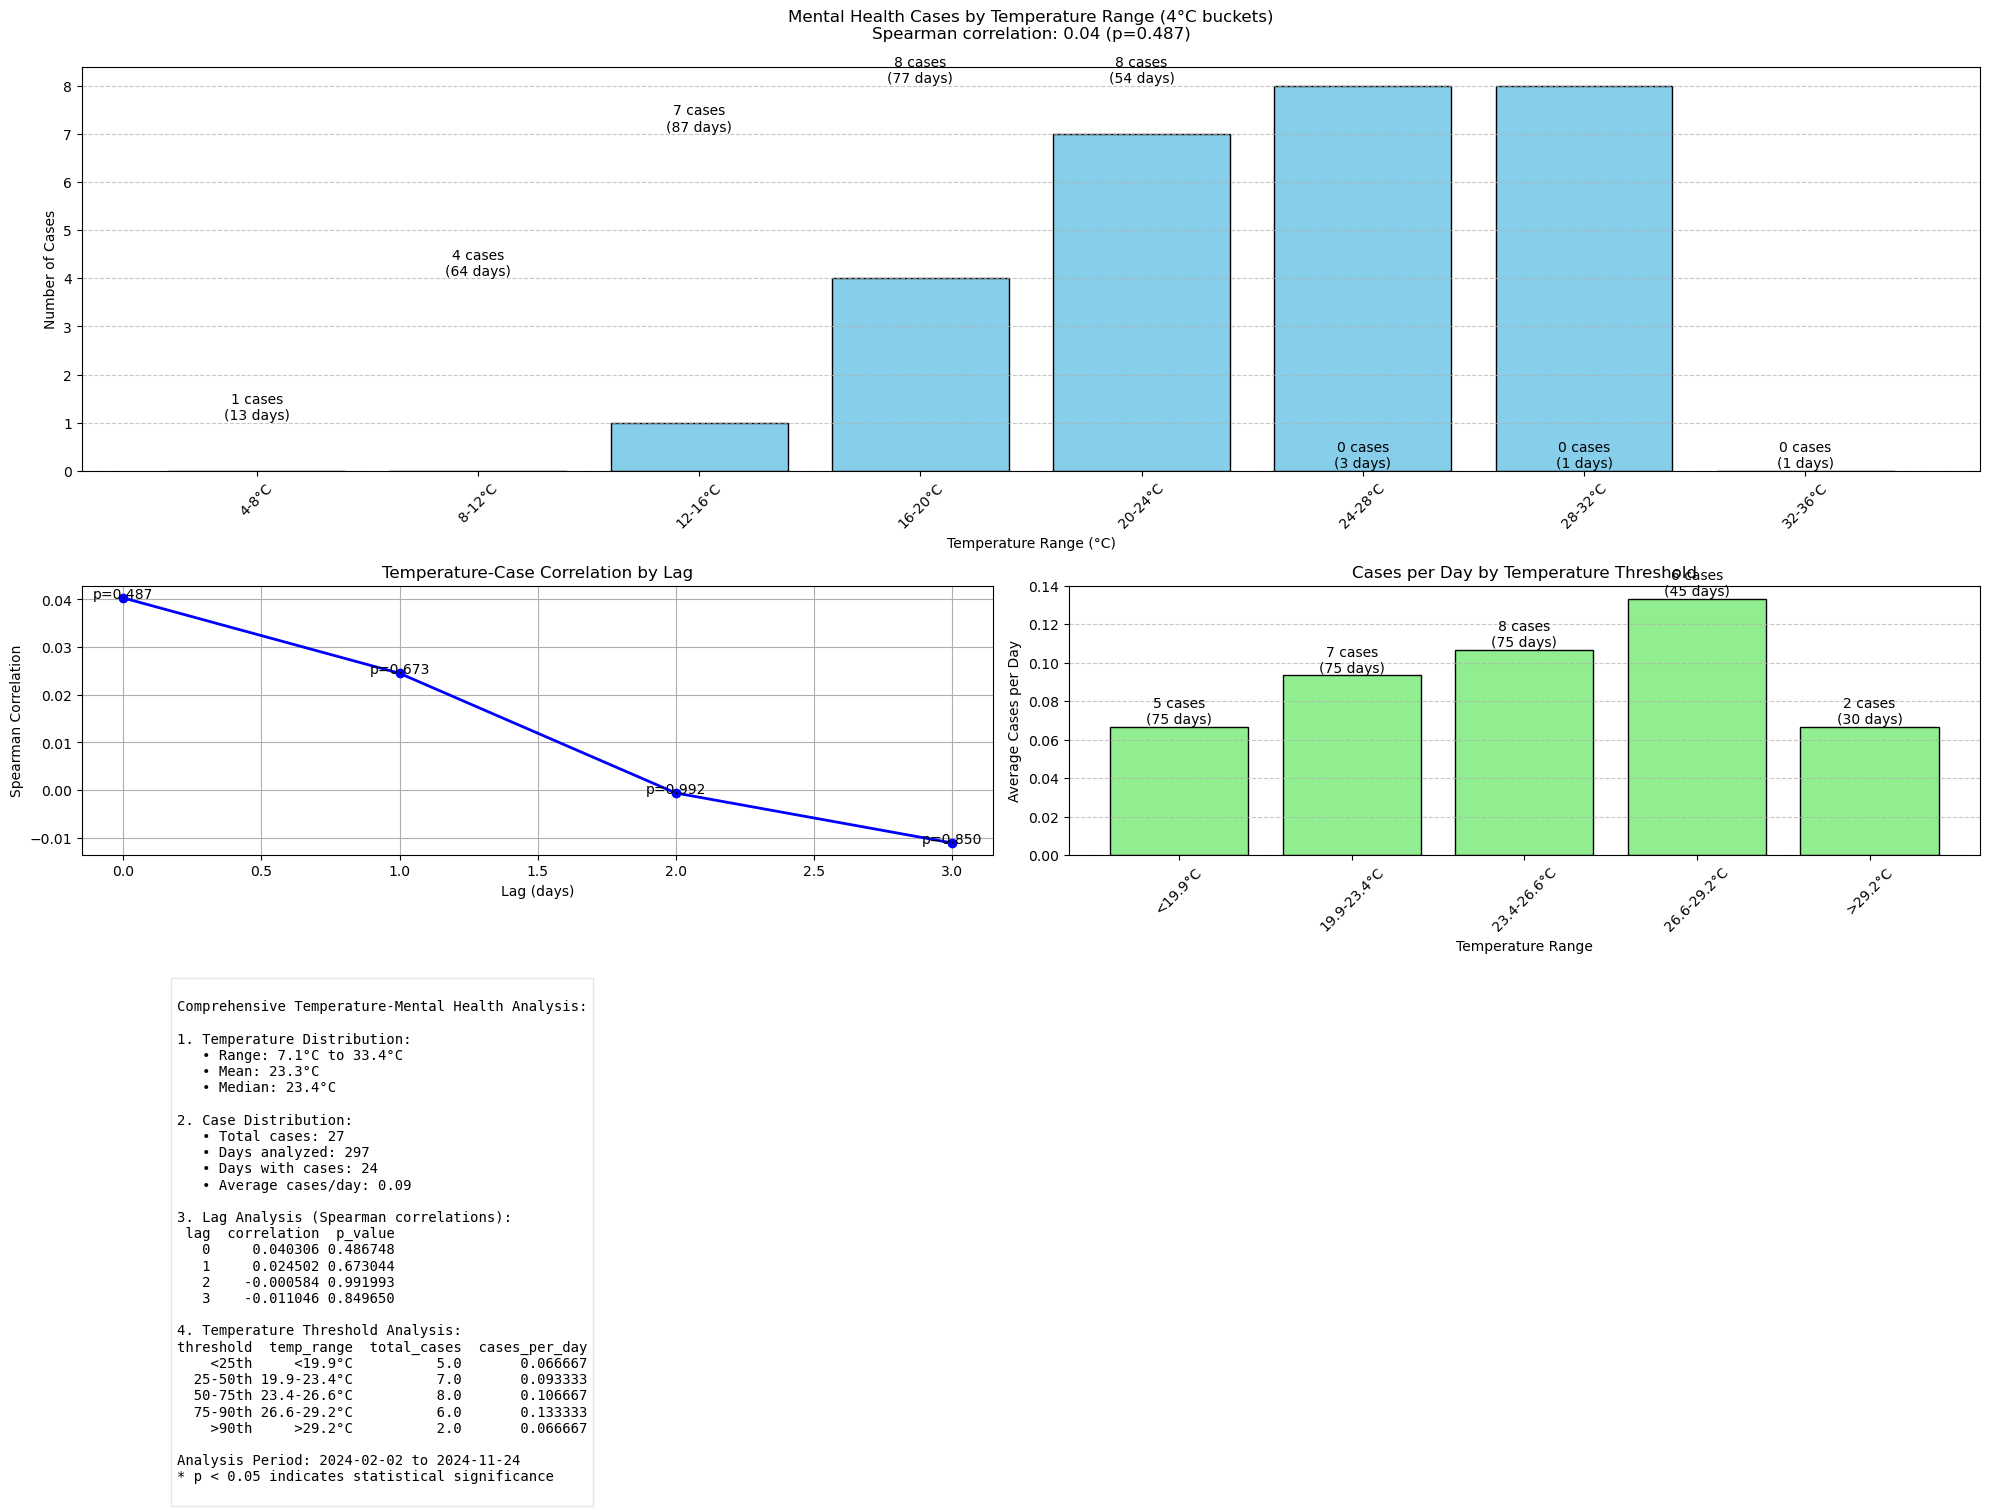

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_temp_health_relationship(climate_df, health_df, bucket_size=4, lag_days=[0, 1, 2, 3]):
    """
    Comprehensive temperature-health analysis with proper lag handling
    """
    # Data preparation
    climate_df = climate_df.copy()
    health_df = health_df.copy()
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create daily case counts DataFrame
    date_range = pd.date_range(start=climate_df['date'].min(),
                             end=climate_df['date'].max())
    daily_cases = pd.DataFrame(index=date_range)
    case_counts = health_df['date'].value_counts()
    daily_cases['cases'] = case_counts.reindex(daily_cases.index).fillna(0)
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 2, height_ratios=[1.5, 1, 1])
    
    # Store lag analysis results
    lag_correlations = []
    
    # Base merged dataset (no lag)
    base_df = pd.DataFrame({
        'date': climate_df['date'],
        'temperature': climate_df['temperature_celsius']
    }).set_index('date')
    
    # Analyze each lag period
    for lag in lag_days:
        # Create lagged temperature data
        temp_lagged = base_df.shift(periods=lag)
        
        # Merge with cases
        merged_df = pd.DataFrame({
            'temperature': temp_lagged['temperature'],
            'cases': daily_cases['cases']
        }).dropna()
        
        # Calculate correlation
        corr, p_value = stats.spearmanr(merged_df['temperature'], merged_df['cases'])
        lag_correlations.append({
            'lag': lag,
            'correlation': corr,
            'p_value': p_value
        })
        
        # For lag 0, create the main analysis
        if lag == 0:
            # Create temperature buckets
            merged_df['temp_bucket'] = (merged_df['temperature'] // bucket_size * bucket_size)
            merged_df['temp_range'] = merged_df['temp_bucket'].apply(
                lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
            )
            
            # Calculate statistics
            temp_analysis = merged_df.groupby('temp_range').agg({
                'cases': ['sum', 'count', 'mean'],
                'temperature': ['mean', 'min', 'max']
            }).round(2)
            
            temp_analysis.columns = ['total_cases', 'days_in_range', 'cases_per_day', 
                                   'mean_temp', 'min_temp', 'max_temp']
            temp_analysis = temp_analysis.reset_index()
            temp_analysis = temp_analysis.sort_values('min_temp')
            
            # Threshold analysis
            temp_thresholds = np.percentile(merged_df['temperature'], [25, 50, 75, 90])
            threshold_analysis = pd.DataFrame({
                'threshold': ['<25th', '25-50th', '50-75th', '75-90th', '>90th'],
                'temp_range': [
                    f"<{temp_thresholds[0]:.1f}°C",
                    f"{temp_thresholds[0]:.1f}-{temp_thresholds[1]:.1f}°C",
                    f"{temp_thresholds[1]:.1f}-{temp_thresholds[2]:.1f}°C",
                    f"{temp_thresholds[2]:.1f}-{temp_thresholds[3]:.1f}°C",
                    f">{temp_thresholds[3]:.1f}°C"
                ]
            })
            
            # Calculate threshold statistics
            for i, row in threshold_analysis.iterrows():
                if i == 0:
                    mask = merged_df['temperature'] < temp_thresholds[0]
                elif i == 4:
                    mask = merged_df['temperature'] > temp_thresholds[3]
                else:
                    mask = (merged_df['temperature'] >= temp_thresholds[i-1]) & \
                           (merged_df['temperature'] < temp_thresholds[i])
                
                threshold_analysis.loc[i, 'total_cases'] = merged_df.loc[mask, 'cases'].sum()
                threshold_analysis.loc[i, 'days'] = mask.sum()
                threshold_analysis.loc[i, 'cases_per_day'] = \
                    merged_df.loc[mask, 'cases'].mean()
            
            # 1. Main bar plot
            ax1 = plt.subplot(gs[0, :])
            bars = ax1.bar(range(len(temp_analysis)), temp_analysis['total_cases'], 
                          color='skyblue', edgecolor='black')
            
            ax1.set_title(f'Mental Health Cases by Temperature Range ({bucket_size}°C buckets)\n' +
                         f'Spearman correlation: {corr:.2f} (p={p_value:.3f})',
                         pad=20)
            ax1.set_xlabel('Temperature Range (°C)')
            ax1.set_ylabel('Number of Cases')
            ax1.set_xticks(range(len(temp_analysis)))
            ax1.set_xticklabels(temp_analysis['temp_range'], rotation=45)
            ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
            
            # Add case counts and days
            for i, row in temp_analysis.iterrows():
                ax1.text(i, row['total_cases'], 
                        f"{int(row['total_cases'])} cases\n({row['days_in_range']} days)", 
                        ha='center', va='bottom')
    
    # 2. Lag analysis plot
    ax2 = plt.subplot(gs[1, 0])
    lag_df = pd.DataFrame(lag_correlations)
    ax2.plot(lag_df['lag'], lag_df['correlation'], 'bo-', linewidth=2)
    ax2.set_xlabel('Lag (days)')
    ax2.set_ylabel('Spearman Correlation')
    ax2.set_title('Temperature-Case Correlation by Lag')
    ax2.grid(True)
    
    # Add significance markers
    for i, row in lag_df.iterrows():
        ax2.text(row['lag'], row['correlation'], 
                f"\np={row['p_value']:.3f}" + ('*' if row['p_value'] < 0.05 else ''),
                ha='center')
    
    # 3. Threshold analysis plot
    ax3 = plt.subplot(gs[1, 1])
    bars = ax3.bar(range(len(threshold_analysis)), threshold_analysis['cases_per_day'],
                   color='lightgreen', edgecolor='black')
    ax3.set_title('Cases per Day by Temperature Threshold')
    ax3.set_xlabel('Temperature Range')
    ax3.set_ylabel('Average Cases per Day')
    ax3.set_xticks(range(len(threshold_analysis)))
    ax3.set_xticklabels(threshold_analysis['temp_range'], rotation=45)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add case counts on bars
    for i, row in threshold_analysis.iterrows():
        ax3.text(i, row['cases_per_day'], 
                f"{row['total_cases']:.0f} cases\n({row['days']:.0f} days)", 
                ha='center', va='bottom')
    
    # 4. Statistical summary
    ax4 = plt.subplot(gs[2, :])
    stats_text = f"""
Comprehensive Temperature-Mental Health Analysis:

1. Temperature Distribution:
   • Range: {merged_df['temperature'].min():.1f}°C to {merged_df['temperature'].max():.1f}°C
   • Mean: {merged_df['temperature'].mean():.1f}°C
   • Median: {merged_df['temperature'].median():.1f}°C

2. Case Distribution:
   • Total cases: {int(merged_df['cases'].sum())}
   • Days analyzed: {len(merged_df)}
   • Days with cases: {(merged_df['cases'] > 0).sum()}
   • Average cases/day: {merged_df['cases'].mean():.2f}

3. Lag Analysis (Spearman correlations):
{lag_df.to_string(index=False)}

4. Temperature Threshold Analysis:
{threshold_analysis[['threshold', 'temp_range', 'total_cases', 'cases_per_day']].to_string(index=False)}

Analysis Period: {merged_df.index.min().strftime('%Y-%m-%d')} to {merged_df.index.max().strftime('%Y-%m-%d')}
* p < 0.05 indicates statistical significance
"""
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.1))
    ax4.axis('off')
    
    plt.tight_layout()
    return plt, temp_analysis, {
        'lag_correlations': lag_correlations,
        'threshold_analysis': threshold_analysis
    }

# Execute the analysis
try:
    print("Loading health data...")
    health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
    
    print("\nStarting analysis...")
    plt, temp_analysis, stats = analyze_temp_health_relationship(
        df,  # Use existing climate data
        health_data, 
        bucket_size=4,  # Larger buckets
        lag_days=[0, 1, 2, 3]  # Analysis of multiple lag periods
    )
    
    plt.show()
    
except Exception as e:
    print(f"Error in analysis: {str(e)}")
    import traceback
    traceback.print_exc()

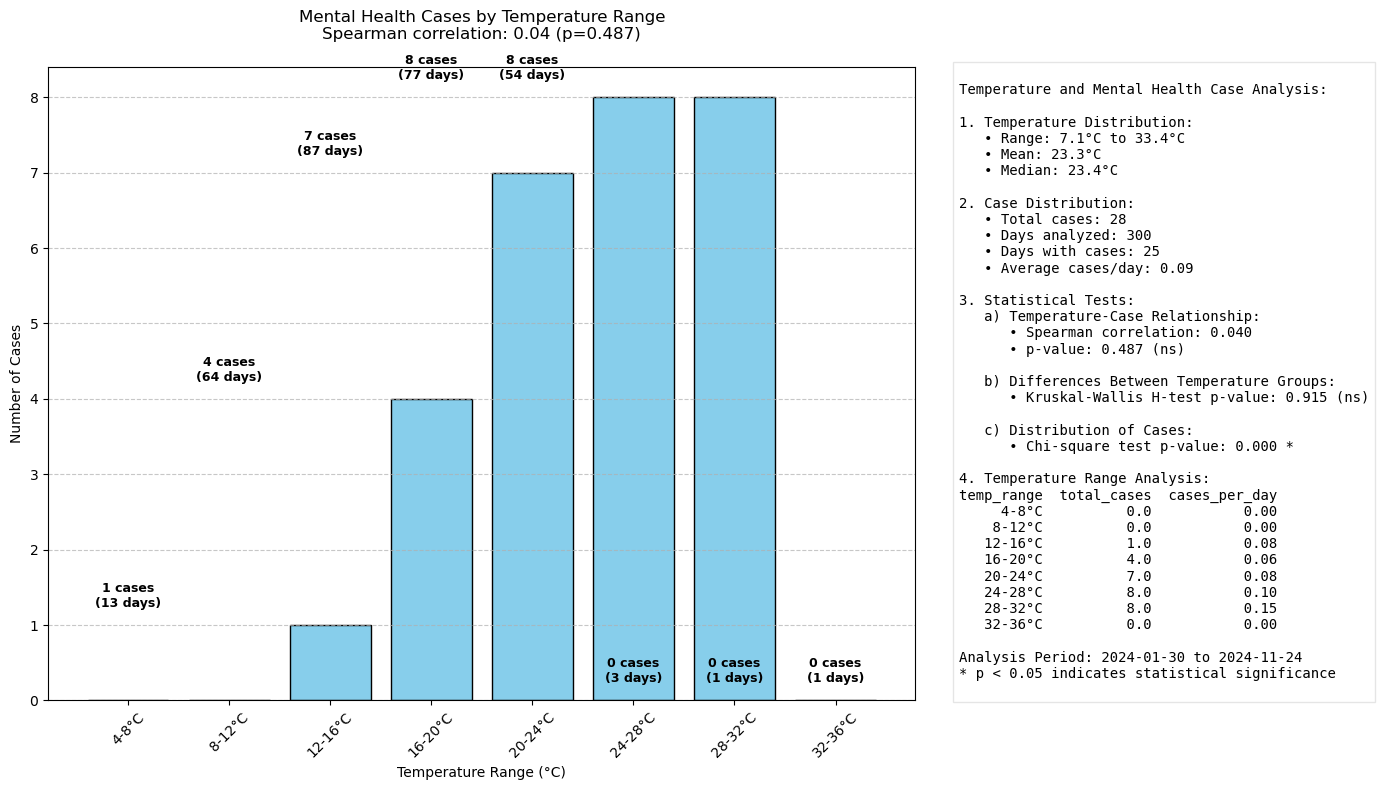

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_temp_health_relationship(climate_df, health_df, bucket_size=4):
    """
    Analyze relationship between temperature and mental health cases
    with basic statistical tests.
    """
    # Data preparation
    climate_df = climate_df.copy()
    health_df = health_df.copy()
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create daily case counts
    daily_cases = pd.DataFrame(index=pd.date_range(start=climate_df['date'].min(),
                                                   end=climate_df['date'].max()))
    case_counts = health_df['date'].value_counts()
    daily_cases['cases'] = case_counts.reindex(daily_cases.index).fillna(0)
    
    # Merge temperature and case data
    merged_df = pd.DataFrame({
        'date': climate_df['date'],
        'temperature': climate_df['temperature_celsius'],
        'cases': daily_cases.loc[climate_df['date'], 'cases'].values
    })
    
    # Create temperature buckets
    merged_df['temp_bucket'] = (merged_df['temperature'] // bucket_size * bucket_size)
    merged_df['temp_range'] = merged_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Calculate statistics by bucket
    temp_analysis = merged_df.groupby('temp_range').agg({
        'cases': ['sum', 'count', 'mean', 'std'],
        'temperature': ['mean', 'min', 'max']
    }).round(2)
    
    temp_analysis.columns = ['total_cases', 'days_in_range', 'cases_per_day', 'cases_std',
                             'mean_temp', 'min_temp', 'max_temp']
    temp_analysis = temp_analysis.reset_index()
    temp_analysis = temp_analysis.sort_values('min_temp')
    
    # Statistical tests
    # 1. Spearman correlation
    corr, p_value = stats.spearmanr(merged_df['temperature'], merged_df['cases'])
    
    # 2. Kruskal-Wallis H-test
    groups = [group['cases'].values for name, group in merged_df.groupby('temp_range')]
    h_stat, h_p = stats.kruskal(*groups)
    
    # 3. Chi-square test for uniformity
    chi2_stat, chi2_p = stats.chisquare(temp_analysis['total_cases'])
    
    # Create a single visualization
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Main bar plot
    bars = ax1.bar(range(len(temp_analysis)), 
                   temp_analysis['total_cases'], 
                   color='skyblue', edgecolor='black')
    
    ax1.set_title('Mental Health Cases by Temperature Range\n' +
                  f'Spearman correlation: {corr:.2f} (p={p_value:.3f})',
                  pad=20)
    ax1.set_xlabel('Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    ax1.set_xticks(range(len(temp_analysis)))
    ax1.set_xticklabels(temp_analysis['temp_range'], rotation=45)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add labels inside or just above bars
    for i, row in temp_analysis.iterrows():
        y_pos = row['total_cases']
        # Place the text slightly above the top of the bar
        ax1.text(i, y_pos + 0.2, 
                 f"{int(row['total_cases'])} cases\n({int(row['days_in_range'])} days)", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Statistical summary text
    stats_text = f"""
Temperature and Mental Health Case Analysis:

1. Temperature Distribution:
   • Range: {merged_df['temperature'].min():.1f}°C to {merged_df['temperature'].max():.1f}°C
   • Mean: {merged_df['temperature'].mean():.1f}°C
   • Median: {merged_df['temperature'].median():.1f}°C

2. Case Distribution:
   • Total cases: {int(merged_df['cases'].sum())}
   • Days analyzed: {len(merged_df)}
   • Days with cases: {(merged_df['cases'] > 0).sum()}
   • Average cases/day: {merged_df['cases'].mean():.2f}

3. Statistical Tests:
   a) Temperature-Case Relationship:
      • Spearman correlation: {corr:.3f}
      • p-value: {p_value:.3f} {'*' if p_value < 0.05 else '(ns)'}

   b) Differences Between Temperature Groups:
      • Kruskal-Wallis H-test p-value: {h_p:.3f} {'*' if h_p < 0.05 else '(ns)'}

   c) Distribution of Cases:
      • Chi-square test p-value: {chi2_p:.3f} {'*' if chi2_p < 0.05 else '(ns)'}

4. Temperature Range Analysis:
{temp_analysis[['temp_range', 'total_cases', 'cases_per_day']].to_string(index=False)}

Analysis Period: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}
* p < 0.05 indicates statistical significance
"""

    # Add stats text to the right side of the plot area
    # Using axes coordinates >1 for x puts it outside the main plot area
    ax1.text(1.05, 1.0, stats_text, transform=ax1.transAxes,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.1))
    
    plt.tight_layout()
    return plt, temp_analysis, {
        'correlation': corr,
        'correlation_p': p_value,
        'kruskal_p': h_p,
        'chi2_p': chi2_p
}

# Example usage (assuming df with climate data and health_data are already loaded):
plt, temp_analysis, stats = analyze_temp_health_relationship(df, health_data, bucket_size=4)
plt.show()


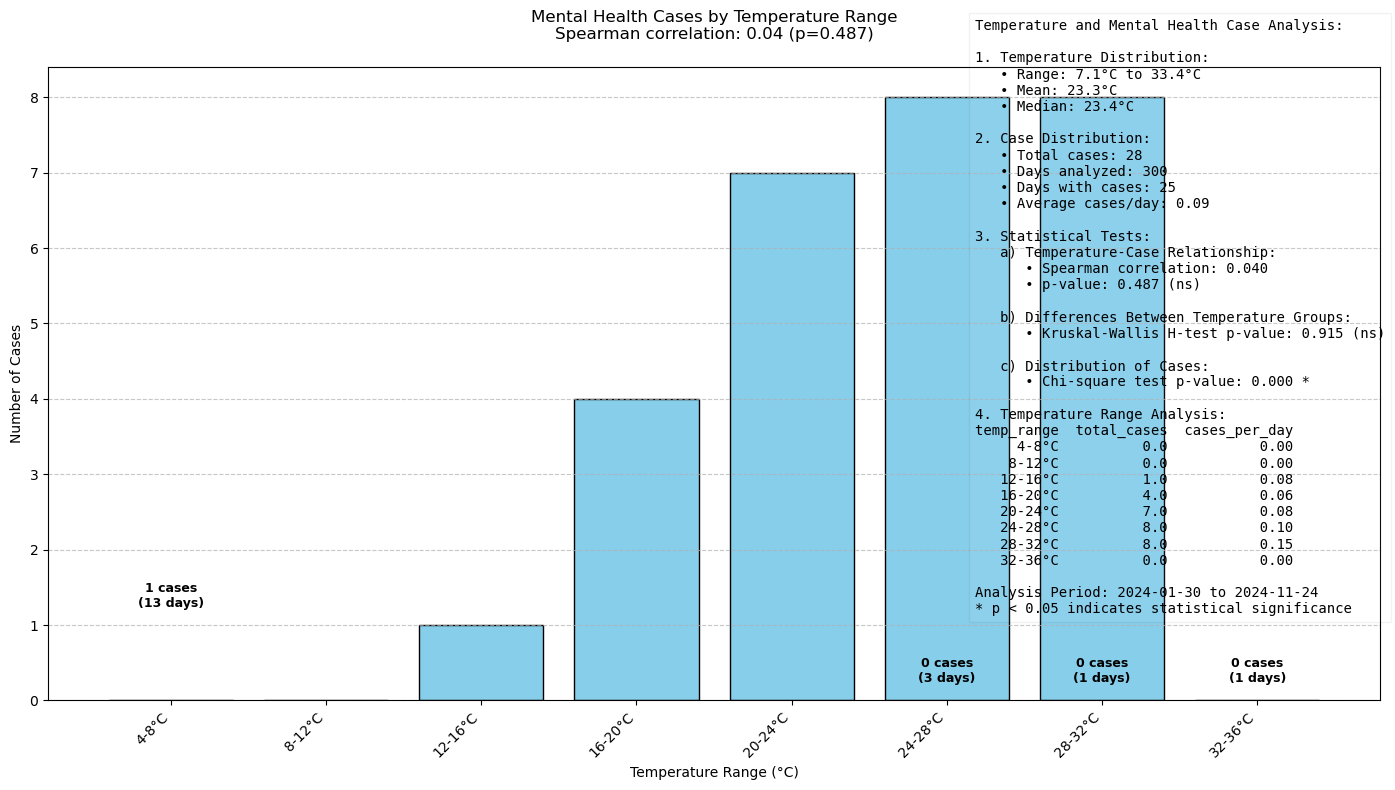

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_temp_health_relationship(climate_df, health_df, bucket_size=4):
    # Data preparation
    climate_df = climate_df.copy()
    health_df = health_df.copy()
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create daily case counts
    daily_cases = pd.DataFrame(index=pd.date_range(start=climate_df['date'].min(),
                                                   end=climate_df['date'].max()))
    case_counts = health_df['date'].value_counts()
    daily_cases['cases'] = case_counts.reindex(daily_cases.index).fillna(0)
    
    # Merge temperature and case data
    merged_df = pd.DataFrame({
        'date': climate_df['date'],
        'temperature': climate_df['temperature_celsius'],
        'cases': daily_cases.loc[climate_df['date'], 'cases'].values
    })
    
    # Create temperature buckets
    merged_df['temp_bucket'] = (merged_df['temperature'] // bucket_size * bucket_size)
    merged_df['temp_range'] = merged_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Calculate statistics by bucket
    temp_analysis = merged_df.groupby('temp_range').agg({
        'cases': ['sum', 'count', 'mean', 'std'],
        'temperature': ['mean', 'min', 'max']
    }).round(2)
    
    temp_analysis.columns = ['total_cases', 'days_in_range', 'cases_per_day', 'cases_std',
                             'mean_temp', 'min_temp', 'max_temp']
    temp_analysis = temp_analysis.reset_index()
    temp_analysis = temp_analysis.sort_values('min_temp')
    
    # Statistical tests
    # 1. Spearman correlation
    corr, p_value = stats.spearmanr(merged_df['temperature'], merged_df['cases'])
    
    # 2. Kruskal-Wallis H-test
    groups = [group['cases'].values for _, group in merged_df.groupby('temp_range')]
    h_stat, h_p = stats.kruskal(*groups)
    
    # 3. Chi-square test for uniformity
    chi2_stat, chi2_p = stats.chisquare(temp_analysis['total_cases'])
    
    # Create a single visualization
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    bars = ax1.bar(range(len(temp_analysis)), 
                   temp_analysis['total_cases'], 
                   color='skyblue', edgecolor='black')
    
    ax1.set_title('Mental Health Cases by Temperature Range\n' +
                  f'Spearman correlation: {corr:.2f} (p={p_value:.3f})',
                  pad=20)
    ax1.set_xlabel('Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    ax1.set_xticks(range(len(temp_analysis)))
    ax1.set_xticklabels(temp_analysis['temp_range'], rotation=45, ha='right')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Label bars
    for i, row in temp_analysis.iterrows():
        height = row['total_cases']
        days = int(row['days_in_range'])
        label = f"{int(row['total_cases'])} cases\n({days} days)"
        
        # If the bar is tall enough, place text inside the bar
        if height > 1.5:
            ax1.text(i, height - 0.3, label,
                     ha='center', va='top', fontsize=9, fontweight='bold', color='white')
        else:
            # If bar is short, place label above the bar
            ax1.text(i, height + 0.2, label,
                     ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')
    
    # Statistical summary text
    stats_text = f"""
Temperature and Mental Health Case Analysis:

1. Temperature Distribution:
   • Range: {merged_df['temperature'].min():.1f}°C to {merged_df['temperature'].max():.1f}°C
   • Mean: {merged_df['temperature'].mean():.1f}°C
   • Median: {merged_df['temperature'].median():.1f}°C

2. Case Distribution:
   • Total cases: {int(merged_df['cases'].sum())}
   • Days analyzed: {len(merged_df)}
   • Days with cases: {(merged_df['cases'] > 0).sum()}
   • Average cases/day: {merged_df['cases'].mean():.2f}

3. Statistical Tests:
   a) Temperature-Case Relationship:
      • Spearman correlation: {corr:.3f}
      • p-value: {p_value:.3f} {'*' if p_value < 0.05 else '(ns)'}
   
   b) Differences Between Temperature Groups:
      • Kruskal-Wallis H-test p-value: {h_p:.3f} {'*' if h_p < 0.05 else '(ns)'}
      
   c) Distribution of Cases:
      • Chi-square test p-value: {chi2_p:.3f} {'*' if chi2_p < 0.05 else '(ns)'}

4. Temperature Range Analysis:
{temp_analysis[['temp_range', 'total_cases', 'cases_per_day']].to_string(index=False)}

Analysis Period: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}
* p < 0.05 indicates statistical significance
""".strip()

    # Adjust subplot to leave space on the right for the stats box
    plt.subplots_adjust(right=0.68)
    
    # Add stats text on the figure level, aligned to the top-right
    fig.text(0.70, 0.97, stats_text, ha='left', va='top', fontsize=10, fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.05))
    
    plt.tight_layout()
    return plt, temp_analysis, {
        'correlation': corr,
        'correlation_p': p_value,
        'kruskal_p': h_p,
        'chi2_p': chi2_p
}

# Example usage
plt, temp_analysis, stats = analyze_temp_health_relationship(df, health_data, bucket_size=4)
plt.show()


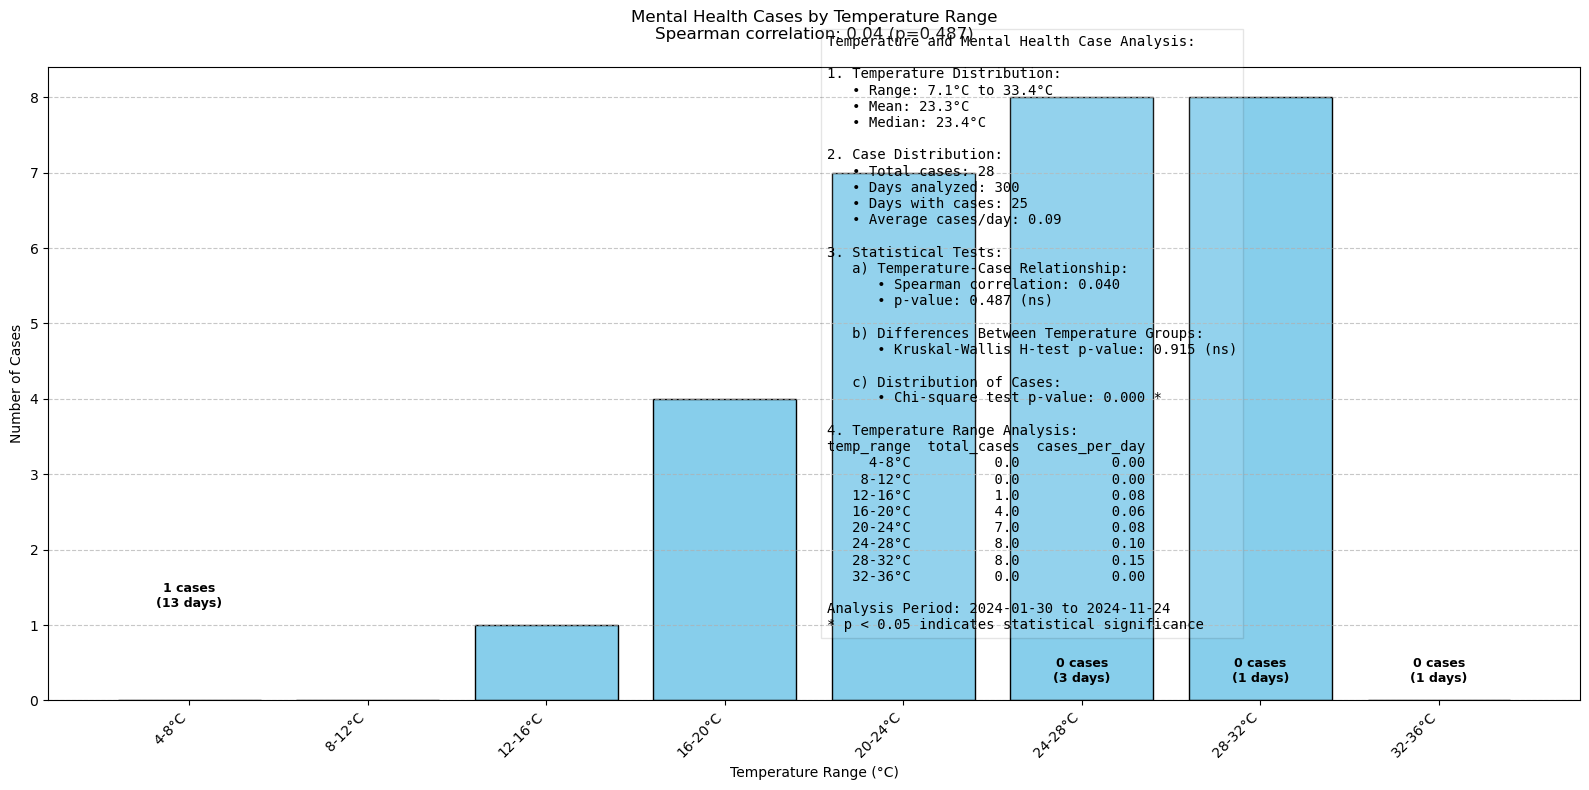

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_temp_health_relationship(climate_df, health_df, bucket_size=4):
    # Data preparation
    climate_df = climate_df.copy()
    health_df = health_df.copy()
    climate_df['date'] = pd.to_datetime(climate_df['date'])
    health_df['date'] = pd.to_datetime(health_df['date'])
    
    # Create daily case counts
    daily_cases = pd.DataFrame(index=pd.date_range(start=climate_df['date'].min(),
                                                   end=climate_df['date'].max()))
    case_counts = health_df['date'].value_counts()
    daily_cases['cases'] = case_counts.reindex(daily_cases.index).fillna(0)
    
    # Merge temperature and case data
    merged_df = pd.DataFrame({
        'date': climate_df['date'],
        'temperature': climate_df['temperature_celsius'],
        'cases': daily_cases.loc[climate_df['date'], 'cases'].values
    })
    
    # Create temperature buckets
    merged_df['temp_bucket'] = (merged_df['temperature'] // bucket_size * bucket_size)
    merged_df['temp_range'] = merged_df['temp_bucket'].apply(
        lambda x: f"{int(x)}-{int(x + bucket_size)}°C"
    )
    
    # Calculate statistics by bucket
    temp_analysis = merged_df.groupby('temp_range').agg({
        'cases': ['sum', 'count', 'mean', 'std'],
        'temperature': ['mean', 'min', 'max']
    }).round(2)
    
    temp_analysis.columns = ['total_cases', 'days_in_range', 'cases_per_day', 'cases_std',
                             'mean_temp', 'min_temp', 'max_temp']
    temp_analysis = temp_analysis.reset_index()
    temp_analysis = temp_analysis.sort_values('min_temp')
    
    # Statistical tests
    # 1. Spearman correlation
    corr, p_value = stats.spearmanr(merged_df['temperature'], merged_df['cases'])
    
    # 2. Kruskal-Wallis H-test
    groups = [group['cases'].values for _, group in merged_df.groupby('temp_range')]
    h_stat, h_p = stats.kruskal(*groups)
    
    # 3. Chi-square test for uniformity
    chi2_stat, chi2_p = stats.chisquare(temp_analysis['total_cases'])
    
    # Create a wider figure to allow space on the right for the text box
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    bars = ax1.bar(range(len(temp_analysis)), 
                   temp_analysis['total_cases'], 
                   color='skyblue', edgecolor='black')
    
    ax1.set_title('Mental Health Cases by Temperature Range\n' +
                  f'Spearman correlation: {corr:.2f} (p={p_value:.3f})',
                  pad=20)
    ax1.set_xlabel('Temperature Range (°C)')
    ax1.set_ylabel('Number of Cases')
    ax1.set_xticks(range(len(temp_analysis)))
    ax1.set_xticklabels(temp_analysis['temp_range'], rotation=45, ha='right')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Label bars
    for i, row in temp_analysis.iterrows():
        height = row['total_cases']
        days = int(row['days_in_range'])
        label = f"{int(row['total_cases'])} cases\n({days} days)"
        
        # If the bar is tall enough, place text inside the bar
        if height > 1.5:
            ax1.text(i, height - 0.3, label,
                     ha='center', va='top', fontsize=9, fontweight='bold', color='white')
        else:
            # If bar is short, place label above the bar
            ax1.text(i, height + 0.2, label,
                     ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')
    
    # Statistical summary text
    stats_text = f"""
Temperature and Mental Health Case Analysis:

1. Temperature Distribution:
   • Range: {merged_df['temperature'].min():.1f}°C to {merged_df['temperature'].max():.1f}°C
   • Mean: {merged_df['temperature'].mean():.1f}°C
   • Median: {merged_df['temperature'].median():.1f}°C

2. Case Distribution:
   • Total cases: {int(merged_df['cases'].sum())}
   • Days analyzed: {len(merged_df)}
   • Days with cases: {(merged_df['cases'] > 0).sum()}
   • Average cases/day: {merged_df['cases'].mean():.2f}

3. Statistical Tests:
   a) Temperature-Case Relationship:
      • Spearman correlation: {corr:.3f}
      • p-value: {p_value:.3f} {'*' if p_value < 0.05 else '(ns)'}
   
   b) Differences Between Temperature Groups:
      • Kruskal-Wallis H-test p-value: {h_p:.3f} {'*' if h_p < 0.05 else '(ns)'}
      
   c) Distribution of Cases:
      • Chi-square test p-value: {chi2_p:.3f} {'*' if chi2_p < 0.05 else '(ns)'}

4. Temperature Range Analysis:
{temp_analysis[['temp_range', 'total_cases', 'cases_per_day']].to_string(index=False)}

Analysis Period: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}
* p < 0.05 indicates statistical significance
""".strip()

    # Adjust subplot to leave more space on the right for the stats box
    plt.subplots_adjust(right=0.5)
    
    # Add stats text to the figure, well to the right of the plot area
    # Note: 0.52 means that starting point is 52% of the figure width from the left
    # Increase or decrease this value based on how far you want the text box.
    fig.text(0.52, 0.95, stats_text, ha='left', va='top', fontsize=10, fontfamily='monospace',
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.1))
    
    plt.tight_layout()
    return plt, temp_analysis, {
        'correlation': corr,
        'correlation_p': p_value,
        'kruskal_p': h_p,
        'chi2_p': chi2_p
}

# After making these changes, the text box should appear to the right side of the plot,
# no longer overlapping the bars.
# Example usage
plt, temp_analysis, stats = analyze_temp_health_relationship(df, health_data, bucket_size=4)
plt.show()
